In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "RAnn"
station_dv = "annual_rain (mm)"
station_path = "data/station_inputs/rain_annual_mean_doy_MSC_25yr_for_maps.csv"
input_model_path = (
    "data/model_inputs/rain_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc"
)
medians = {"value": 726, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,annual_rain (mm),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,793.0,-4.517790,10.457750,42.0333,-82.9000,191.0,HARROW CDA,ON,884.890747,1.039557
1,553,1007,850.0,-4.474659,10.302673,42.1034,-83.0945,182.0,AMHERSTBURG,ON,892.609375,1.104644
2,553,1015,773.0,-4.477661,10.621608,42.0431,-82.6739,200.0,KINGSVILLE MOE,ON,881.386108,1.017368


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

31.5

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/1365 [00:00<?, ?it/s]

  0%|          | 2/1365 [00:00<08:44,  2.60it/s]

  0%|          | 3/1365 [00:01<11:01,  2.06it/s]

  0%|          | 4/1365 [00:02<12:41,  1.79it/s]

  0%|          | 5/1365 [00:02<14:00,  1.62it/s]

  0%|          | 6/1365 [00:03<14:59,  1.51it/s]

  1%|          | 7/1365 [00:04<15:59,  1.42it/s]

  1%|          | 8/1365 [00:05<16:02,  1.41it/s]

  1%|          | 9/1365 [00:06<16:18,  1.39it/s]

  1%|          | 10/1365 [00:06<15:56,  1.42it/s]

  1%|          | 11/1365 [00:07<15:33,  1.45it/s]

  1%|          | 12/1365 [00:08<15:32,  1.45it/s]

  1%|          | 13/1365 [00:08<15:45,  1.43it/s]

  1%|          | 14/1365 [00:09<15:35,  1.44it/s]

  1%|          | 15/1365 [00:10<15:49,  1.42it/s]

  1%|          | 16/1365 [00:10<15:26,  1.46it/s]

  1%|          | 17/1365 [00:11<15:27,  1.45it/s]

  1%|▏         | 18/1365 [00:12<15:40,  1.43it/s]

  1%|▏         | 19/1365 [00:12<15:10,  1.48it/s]

  1%|▏         | 20/1365 [00:13<15:10,  1.48it/s]

  2%|▏         | 21/1365 [00:14<15:34,  1.44it/s]

  2%|▏         | 22/1365 [00:14<15:23,  1.45it/s]

  2%|▏         | 23/1365 [00:15<15:36,  1.43it/s]

  2%|▏         | 24/1365 [00:16<16:13,  1.38it/s]

  2%|▏         | 25/1365 [00:17<16:08,  1.38it/s]

  2%|▏         | 26/1365 [00:17<15:37,  1.43it/s]

  2%|▏         | 27/1365 [00:18<15:32,  1.43it/s]

  2%|▏         | 28/1365 [00:19<15:31,  1.43it/s]

  2%|▏         | 29/1365 [00:19<15:11,  1.47it/s]

  2%|▏         | 30/1365 [00:20<15:19,  1.45it/s]

  2%|▏         | 31/1365 [00:21<15:35,  1.43it/s]

  2%|▏         | 32/1365 [00:21<15:28,  1.44it/s]

  2%|▏         | 33/1365 [00:22<15:22,  1.44it/s]

  2%|▏         | 34/1365 [00:23<15:35,  1.42it/s]

  3%|▎         | 35/1365 [00:24<15:31,  1.43it/s]

  3%|▎         | 36/1365 [00:24<15:30,  1.43it/s]

  3%|▎         | 37/1365 [00:25<15:23,  1.44it/s]

  3%|▎         | 38/1365 [00:26<15:08,  1.46it/s]

  3%|▎         | 39/1365 [00:26<15:05,  1.46it/s]

  3%|▎         | 40/1365 [00:27<14:57,  1.48it/s]

  3%|▎         | 41/1365 [00:28<14:48,  1.49it/s]

  3%|▎         | 42/1365 [00:28<14:16,  1.54it/s]

  3%|▎         | 43/1365 [00:29<14:00,  1.57it/s]

  3%|▎         | 44/1365 [00:29<13:59,  1.57it/s]

  3%|▎         | 45/1365 [00:30<13:51,  1.59it/s]

  3%|▎         | 46/1365 [00:31<13:47,  1.59it/s]

  3%|▎         | 47/1365 [00:31<13:57,  1.57it/s]

  4%|▎         | 48/1365 [00:32<13:59,  1.57it/s]

  4%|▎         | 49/1365 [00:33<14:06,  1.56it/s]

  4%|▎         | 50/1365 [00:33<14:05,  1.55it/s]

  4%|▎         | 51/1365 [00:34<14:06,  1.55it/s]

  4%|▍         | 52/1365 [00:35<14:06,  1.55it/s]

  4%|▍         | 53/1365 [00:35<14:09,  1.55it/s]

  4%|▍         | 54/1365 [00:36<14:14,  1.53it/s]

  4%|▍         | 55/1365 [00:37<14:22,  1.52it/s]

  4%|▍         | 56/1365 [00:37<14:19,  1.52it/s]

  4%|▍         | 57/1365 [00:38<14:22,  1.52it/s]

  4%|▍         | 58/1365 [00:39<14:36,  1.49it/s]

  4%|▍         | 59/1365 [00:39<14:40,  1.48it/s]

  4%|▍         | 60/1365 [00:40<14:36,  1.49it/s]

  4%|▍         | 61/1365 [00:41<14:28,  1.50it/s]

  5%|▍         | 62/1365 [00:41<14:54,  1.46it/s]

  5%|▍         | 63/1365 [00:42<15:07,  1.43it/s]

  5%|▍         | 64/1365 [00:43<15:08,  1.43it/s]

  5%|▍         | 65/1365 [00:43<14:54,  1.45it/s]

  5%|▍         | 66/1365 [00:44<15:11,  1.43it/s]

  5%|▍         | 67/1365 [00:45<14:50,  1.46it/s]

  5%|▍         | 68/1365 [00:46<15:07,  1.43it/s]

  5%|▌         | 69/1365 [00:46<15:04,  1.43it/s]

  5%|▌         | 70/1365 [00:47<14:40,  1.47it/s]

  5%|▌         | 71/1365 [00:47<14:28,  1.49it/s]

  5%|▌         | 72/1365 [00:48<14:15,  1.51it/s]

  5%|▌         | 73/1365 [00:49<14:28,  1.49it/s]

  5%|▌         | 74/1365 [00:49<14:17,  1.50it/s]

  5%|▌         | 75/1365 [00:50<14:15,  1.51it/s]

  6%|▌         | 76/1365 [00:51<14:27,  1.49it/s]

  6%|▌         | 77/1365 [00:52<14:45,  1.45it/s]

  6%|▌         | 78/1365 [00:52<14:40,  1.46it/s]

  6%|▌         | 79/1365 [00:53<14:23,  1.49it/s]

  6%|▌         | 80/1365 [00:54<14:26,  1.48it/s]

  6%|▌         | 81/1365 [00:54<14:25,  1.48it/s]

  6%|▌         | 82/1365 [00:55<14:01,  1.52it/s]

  6%|▌         | 83/1365 [00:55<13:52,  1.54it/s]

  6%|▌         | 84/1365 [00:56<13:45,  1.55it/s]

  6%|▌         | 85/1365 [00:57<13:38,  1.56it/s]

  6%|▋         | 86/1365 [00:57<14:09,  1.51it/s]

  6%|▋         | 87/1365 [00:58<14:46,  1.44it/s]

  6%|▋         | 88/1365 [00:59<14:59,  1.42it/s]

  7%|▋         | 89/1365 [01:00<15:20,  1.39it/s]

  7%|▋         | 90/1365 [01:00<15:21,  1.38it/s]

  7%|▋         | 91/1365 [01:01<15:29,  1.37it/s]

  7%|▋         | 92/1365 [01:02<15:08,  1.40it/s]

  7%|▋         | 93/1365 [01:03<15:27,  1.37it/s]

  7%|▋         | 94/1365 [01:03<15:33,  1.36it/s]

  7%|▋         | 95/1365 [01:04<15:36,  1.36it/s]

  7%|▋         | 96/1365 [01:05<15:21,  1.38it/s]

  7%|▋         | 97/1365 [01:06<15:14,  1.39it/s]

  7%|▋         | 98/1365 [01:06<15:44,  1.34it/s]

  7%|▋         | 99/1365 [01:07<15:32,  1.36it/s]

  7%|▋         | 100/1365 [01:08<15:06,  1.40it/s]

  7%|▋         | 101/1365 [01:08<14:51,  1.42it/s]

  7%|▋         | 102/1365 [01:09<14:56,  1.41it/s]

  8%|▊         | 103/1365 [01:10<14:57,  1.41it/s]

  8%|▊         | 104/1365 [01:10<14:42,  1.43it/s]

  8%|▊         | 105/1365 [01:11<14:56,  1.41it/s]

  8%|▊         | 106/1365 [01:12<14:30,  1.45it/s]

  8%|▊         | 107/1365 [01:13<14:45,  1.42it/s]

  8%|▊         | 108/1365 [01:13<14:37,  1.43it/s]

  8%|▊         | 109/1365 [01:14<14:30,  1.44it/s]

  8%|▊         | 110/1365 [01:15<14:16,  1.47it/s]

  8%|▊         | 111/1365 [01:15<14:36,  1.43it/s]

  8%|▊         | 112/1365 [01:16<14:35,  1.43it/s]

  8%|▊         | 113/1365 [01:17<14:35,  1.43it/s]

  8%|▊         | 114/1365 [01:17<14:30,  1.44it/s]

  8%|▊         | 115/1365 [01:18<14:34,  1.43it/s]

  8%|▊         | 116/1365 [01:19<14:19,  1.45it/s]

  9%|▊         | 117/1365 [01:19<14:11,  1.47it/s]

  9%|▊         | 118/1365 [01:20<14:16,  1.46it/s]

  9%|▊         | 119/1365 [01:21<14:04,  1.48it/s]

  9%|▉         | 120/1365 [01:22<13:54,  1.49it/s]

  9%|▉         | 121/1365 [01:22<13:42,  1.51it/s]

  9%|▉         | 122/1365 [01:23<13:44,  1.51it/s]

  9%|▉         | 123/1365 [01:23<13:37,  1.52it/s]

  9%|▉         | 124/1365 [01:24<13:29,  1.53it/s]

  9%|▉         | 125/1365 [01:25<13:29,  1.53it/s]

  9%|▉         | 126/1365 [01:25<13:32,  1.52it/s]

  9%|▉         | 127/1365 [01:26<13:38,  1.51it/s]

  9%|▉         | 128/1365 [01:27<13:38,  1.51it/s]

  9%|▉         | 129/1365 [01:27<13:35,  1.52it/s]

 10%|▉         | 130/1365 [01:28<13:31,  1.52it/s]

 10%|▉         | 131/1365 [01:29<13:25,  1.53it/s]

 10%|▉         | 132/1365 [01:29<13:26,  1.53it/s]

 10%|▉         | 133/1365 [01:30<13:25,  1.53it/s]

 10%|▉         | 134/1365 [01:31<13:42,  1.50it/s]

 10%|▉         | 135/1365 [01:31<13:45,  1.49it/s]

 10%|▉         | 136/1365 [01:32<13:47,  1.48it/s]

 10%|█         | 137/1365 [01:33<13:52,  1.48it/s]

 10%|█         | 138/1365 [01:33<13:53,  1.47it/s]

 10%|█         | 139/1365 [01:34<13:48,  1.48it/s]

 10%|█         | 140/1365 [01:35<14:01,  1.46it/s]

 10%|█         | 141/1365 [01:36<14:05,  1.45it/s]

 10%|█         | 142/1365 [01:36<14:16,  1.43it/s]

 10%|█         | 143/1365 [01:37<14:41,  1.39it/s]

 11%|█         | 144/1365 [01:38<15:11,  1.34it/s]

 11%|█         | 145/1365 [01:38<14:44,  1.38it/s]

 11%|█         | 146/1365 [01:39<14:18,  1.42it/s]

 11%|█         | 147/1365 [01:40<14:51,  1.37it/s]

 11%|█         | 148/1365 [01:41<14:44,  1.38it/s]

 11%|█         | 149/1365 [01:41<14:36,  1.39it/s]

 11%|█         | 150/1365 [01:42<14:30,  1.40it/s]

 11%|█         | 151/1365 [01:43<14:16,  1.42it/s]

 11%|█         | 152/1365 [01:43<14:01,  1.44it/s]

 11%|█         | 153/1365 [01:44<13:38,  1.48it/s]

 11%|█▏        | 154/1365 [01:45<13:48,  1.46it/s]

 11%|█▏        | 155/1365 [01:45<13:27,  1.50it/s]

 11%|█▏        | 156/1365 [01:46<13:44,  1.47it/s]

 12%|█▏        | 157/1365 [01:47<13:45,  1.46it/s]

 12%|█▏        | 158/1365 [01:48<14:12,  1.42it/s]

 12%|█▏        | 159/1365 [01:48<13:58,  1.44it/s]

 12%|█▏        | 160/1365 [01:49<14:15,  1.41it/s]

 12%|█▏        | 161/1365 [01:50<14:05,  1.42it/s]

 12%|█▏        | 162/1365 [01:50<13:48,  1.45it/s]

 12%|█▏        | 163/1365 [01:51<13:52,  1.44it/s]

 12%|█▏        | 164/1365 [01:52<13:48,  1.45it/s]

 12%|█▏        | 165/1365 [01:52<13:29,  1.48it/s]

 12%|█▏        | 166/1365 [01:53<13:25,  1.49it/s]

 12%|█▏        | 167/1365 [01:54<13:23,  1.49it/s]

 12%|█▏        | 168/1365 [01:54<13:36,  1.47it/s]

 12%|█▏        | 169/1365 [01:55<13:38,  1.46it/s]

 12%|█▏        | 170/1365 [01:56<13:18,  1.50it/s]

 13%|█▎        | 171/1365 [01:56<13:27,  1.48it/s]

 13%|█▎        | 172/1365 [01:57<13:24,  1.48it/s]

 13%|█▎        | 173/1365 [01:58<13:27,  1.48it/s]

 13%|█▎        | 174/1365 [01:58<13:45,  1.44it/s]

 13%|█▎        | 175/1365 [01:59<13:50,  1.43it/s]

 13%|█▎        | 176/1365 [02:00<13:43,  1.44it/s]

 13%|█▎        | 177/1365 [02:01<13:43,  1.44it/s]

 13%|█▎        | 178/1365 [02:01<13:39,  1.45it/s]

 13%|█▎        | 179/1365 [02:02<13:42,  1.44it/s]

 13%|█▎        | 180/1365 [02:03<13:40,  1.44it/s]

 13%|█▎        | 181/1365 [02:03<13:38,  1.45it/s]

 13%|█▎        | 182/1365 [02:04<13:45,  1.43it/s]

 13%|█▎        | 183/1365 [02:05<13:42,  1.44it/s]

 13%|█▎        | 184/1365 [02:05<13:35,  1.45it/s]

 14%|█▎        | 185/1365 [02:06<13:36,  1.44it/s]

 14%|█▎        | 186/1365 [02:07<13:37,  1.44it/s]

 14%|█▎        | 187/1365 [02:07<13:41,  1.43it/s]

 14%|█▍        | 188/1365 [02:08<13:53,  1.41it/s]

 14%|█▍        | 189/1365 [02:09<14:08,  1.39it/s]

 14%|█▍        | 190/1365 [02:10<13:54,  1.41it/s]

 14%|█▍        | 191/1365 [02:10<13:45,  1.42it/s]

 14%|█▍        | 192/1365 [02:11<13:44,  1.42it/s]

 14%|█▍        | 193/1365 [02:12<13:52,  1.41it/s]

 14%|█▍        | 194/1365 [02:12<13:52,  1.41it/s]

 14%|█▍        | 195/1365 [02:13<13:56,  1.40it/s]

 14%|█▍        | 196/1365 [02:14<13:46,  1.41it/s]

 14%|█▍        | 197/1365 [02:15<13:42,  1.42it/s]

 15%|█▍        | 198/1365 [02:15<13:43,  1.42it/s]

 15%|█▍        | 199/1365 [02:16<13:48,  1.41it/s]

 15%|█▍        | 200/1365 [02:17<13:55,  1.39it/s]

 15%|█▍        | 201/1365 [02:17<13:50,  1.40it/s]

 15%|█▍        | 202/1365 [02:18<13:36,  1.42it/s]

 15%|█▍        | 203/1365 [02:19<13:27,  1.44it/s]

 15%|█▍        | 204/1365 [02:20<13:30,  1.43it/s]

 15%|█▌        | 205/1365 [02:20<13:50,  1.40it/s]

 15%|█▌        | 206/1365 [02:21<13:48,  1.40it/s]

 15%|█▌        | 207/1365 [02:22<13:54,  1.39it/s]

 15%|█▌        | 208/1365 [02:22<13:56,  1.38it/s]

 15%|█▌        | 209/1365 [02:23<14:05,  1.37it/s]

 15%|█▌        | 210/1365 [02:24<14:02,  1.37it/s]

 15%|█▌        | 211/1365 [02:25<14:02,  1.37it/s]

 16%|█▌        | 212/1365 [02:26<15:06,  1.27it/s]

 16%|█▌        | 213/1365 [02:26<15:12,  1.26it/s]

 16%|█▌        | 214/1365 [02:27<14:45,  1.30it/s]

 16%|█▌        | 215/1365 [02:28<14:31,  1.32it/s]

 16%|█▌        | 216/1365 [02:29<14:23,  1.33it/s]

 16%|█▌        | 217/1365 [02:29<14:04,  1.36it/s]

 16%|█▌        | 218/1365 [02:30<13:50,  1.38it/s]

 16%|█▌        | 219/1365 [02:31<13:42,  1.39it/s]

 16%|█▌        | 220/1365 [02:31<14:08,  1.35it/s]

 16%|█▌        | 221/1365 [02:32<13:51,  1.38it/s]

 16%|█▋        | 222/1365 [02:33<13:38,  1.40it/s]

 16%|█▋        | 223/1365 [02:34<13:58,  1.36it/s]

 16%|█▋        | 224/1365 [02:34<13:44,  1.38it/s]

 16%|█▋        | 225/1365 [02:35<13:49,  1.37it/s]

 17%|█▋        | 226/1365 [02:36<13:51,  1.37it/s]

 17%|█▋        | 227/1365 [02:37<13:46,  1.38it/s]

 17%|█▋        | 228/1365 [02:37<13:26,  1.41it/s]

 17%|█▋        | 229/1365 [02:38<13:26,  1.41it/s]

 17%|█▋        | 230/1365 [02:39<13:22,  1.41it/s]

 17%|█▋        | 231/1365 [02:39<13:30,  1.40it/s]

 17%|█▋        | 232/1365 [02:40<13:24,  1.41it/s]

 17%|█▋        | 233/1365 [02:41<13:19,  1.42it/s]

 17%|█▋        | 234/1365 [02:41<13:25,  1.40it/s]

 17%|█▋        | 235/1365 [02:42<13:18,  1.42it/s]

 17%|█▋        | 236/1365 [02:43<13:16,  1.42it/s]

 17%|█▋        | 237/1365 [02:44<13:09,  1.43it/s]

 17%|█▋        | 238/1365 [02:44<13:21,  1.41it/s]

 18%|█▊        | 239/1365 [02:45<13:22,  1.40it/s]

 18%|█▊        | 240/1365 [02:46<13:03,  1.44it/s]

 18%|█▊        | 241/1365 [02:46<12:55,  1.45it/s]

 18%|█▊        | 242/1365 [02:47<12:44,  1.47it/s]

 18%|█▊        | 243/1365 [02:48<12:38,  1.48it/s]

 18%|█▊        | 244/1365 [02:48<12:46,  1.46it/s]

 18%|█▊        | 245/1365 [02:49<12:53,  1.45it/s]

 18%|█▊        | 246/1365 [02:50<12:57,  1.44it/s]

 18%|█▊        | 247/1365 [02:50<12:56,  1.44it/s]

 18%|█▊        | 248/1365 [02:51<13:03,  1.43it/s]

 18%|█▊        | 249/1365 [02:52<12:56,  1.44it/s]

 18%|█▊        | 250/1365 [02:53<12:59,  1.43it/s]

 18%|█▊        | 251/1365 [02:53<13:03,  1.42it/s]

 18%|█▊        | 252/1365 [02:54<13:08,  1.41it/s]

 19%|█▊        | 253/1365 [02:55<13:11,  1.40it/s]

 19%|█▊        | 254/1365 [02:55<13:00,  1.42it/s]

 19%|█▊        | 255/1365 [02:56<12:55,  1.43it/s]

 19%|█▉        | 256/1365 [02:57<13:00,  1.42it/s]

 19%|█▉        | 257/1365 [02:57<12:41,  1.45it/s]

 19%|█▉        | 258/1365 [02:58<12:30,  1.48it/s]

 19%|█▉        | 259/1365 [02:59<12:45,  1.44it/s]

 19%|█▉        | 260/1365 [03:00<12:48,  1.44it/s]

 19%|█▉        | 261/1365 [03:00<12:47,  1.44it/s]

 19%|█▉        | 262/1365 [03:01<12:46,  1.44it/s]

 19%|█▉        | 263/1365 [03:02<12:44,  1.44it/s]

 19%|█▉        | 264/1365 [03:02<12:43,  1.44it/s]

 19%|█▉        | 265/1365 [03:03<12:36,  1.45it/s]

 19%|█▉        | 266/1365 [03:04<12:37,  1.45it/s]

 20%|█▉        | 267/1365 [03:04<12:42,  1.44it/s]

 20%|█▉        | 268/1365 [03:05<12:58,  1.41it/s]

 20%|█▉        | 269/1365 [03:06<12:48,  1.43it/s]

 20%|█▉        | 270/1365 [03:07<12:46,  1.43it/s]

 20%|█▉        | 271/1365 [03:07<12:46,  1.43it/s]

 20%|█▉        | 272/1365 [03:08<12:35,  1.45it/s]

 20%|██        | 273/1365 [03:09<12:26,  1.46it/s]

 20%|██        | 274/1365 [03:09<12:24,  1.47it/s]

 20%|██        | 275/1365 [03:10<12:28,  1.46it/s]

 20%|██        | 276/1365 [03:11<12:34,  1.44it/s]

 20%|██        | 277/1365 [03:11<12:40,  1.43it/s]

 20%|██        | 278/1365 [03:12<13:01,  1.39it/s]

 20%|██        | 279/1365 [03:13<13:04,  1.38it/s]

 21%|██        | 280/1365 [03:14<13:00,  1.39it/s]

 21%|██        | 281/1365 [03:14<12:44,  1.42it/s]

 21%|██        | 282/1365 [03:15<12:41,  1.42it/s]

 21%|██        | 283/1365 [03:16<13:15,  1.36it/s]

 21%|██        | 284/1365 [03:16<13:16,  1.36it/s]

 21%|██        | 285/1365 [03:17<12:42,  1.42it/s]

 21%|██        | 286/1365 [03:18<12:21,  1.45it/s]

 21%|██        | 287/1365 [03:18<12:06,  1.48it/s]

 21%|██        | 288/1365 [03:19<11:59,  1.50it/s]

 21%|██        | 289/1365 [03:20<12:08,  1.48it/s]

 21%|██        | 290/1365 [03:20<11:55,  1.50it/s]

 21%|██▏       | 291/1365 [03:21<11:56,  1.50it/s]

 21%|██▏       | 292/1365 [03:22<11:53,  1.50it/s]

 21%|██▏       | 293/1365 [03:22<11:54,  1.50it/s]

 22%|██▏       | 294/1365 [03:23<12:10,  1.47it/s]

 22%|██▏       | 295/1365 [03:24<12:15,  1.45it/s]

 22%|██▏       | 296/1365 [03:24<12:12,  1.46it/s]

 22%|██▏       | 297/1365 [03:25<12:11,  1.46it/s]

 22%|██▏       | 298/1365 [03:26<12:01,  1.48it/s]

 22%|██▏       | 299/1365 [03:27<12:04,  1.47it/s]

 22%|██▏       | 300/1365 [03:27<12:05,  1.47it/s]

 22%|██▏       | 301/1365 [03:28<11:56,  1.48it/s]

 22%|██▏       | 302/1365 [03:29<11:46,  1.50it/s]

 22%|██▏       | 303/1365 [03:29<11:38,  1.52it/s]

 22%|██▏       | 304/1365 [03:30<11:33,  1.53it/s]

 22%|██▏       | 305/1365 [03:30<11:37,  1.52it/s]

 22%|██▏       | 306/1365 [03:31<11:33,  1.53it/s]

 22%|██▏       | 307/1365 [03:32<11:30,  1.53it/s]

 23%|██▎       | 308/1365 [03:32<11:41,  1.51it/s]

 23%|██▎       | 309/1365 [03:33<11:35,  1.52it/s]

 23%|██▎       | 310/1365 [03:34<11:28,  1.53it/s]

 23%|██▎       | 311/1365 [03:34<11:56,  1.47it/s]

 23%|██▎       | 312/1365 [03:35<12:16,  1.43it/s]

 23%|██▎       | 313/1365 [03:36<12:12,  1.44it/s]

 23%|██▎       | 314/1365 [03:37<11:50,  1.48it/s]

 23%|██▎       | 315/1365 [03:37<11:51,  1.48it/s]

 23%|██▎       | 316/1365 [03:38<11:46,  1.49it/s]

 23%|██▎       | 317/1365 [03:39<11:44,  1.49it/s]

 23%|██▎       | 318/1365 [03:39<11:47,  1.48it/s]

 23%|██▎       | 319/1365 [03:40<11:36,  1.50it/s]

 23%|██▎       | 320/1365 [03:41<11:40,  1.49it/s]

 24%|██▎       | 321/1365 [03:41<11:36,  1.50it/s]

 24%|██▎       | 322/1365 [03:42<11:25,  1.52it/s]

 24%|██▎       | 323/1365 [03:43<11:33,  1.50it/s]

 24%|██▎       | 324/1365 [03:43<11:27,  1.52it/s]

 24%|██▍       | 325/1365 [03:44<11:52,  1.46it/s]

 24%|██▍       | 326/1365 [03:45<12:10,  1.42it/s]

 24%|██▍       | 327/1365 [03:45<12:08,  1.43it/s]

 24%|██▍       | 328/1365 [03:46<12:10,  1.42it/s]

 24%|██▍       | 329/1365 [03:47<12:01,  1.44it/s]

 24%|██▍       | 330/1365 [03:47<11:42,  1.47it/s]

 24%|██▍       | 331/1365 [03:48<11:31,  1.49it/s]

 24%|██▍       | 332/1365 [03:49<11:52,  1.45it/s]

 24%|██▍       | 333/1365 [03:49<12:02,  1.43it/s]

 24%|██▍       | 334/1365 [03:50<11:43,  1.47it/s]

 25%|██▍       | 335/1365 [03:51<11:34,  1.48it/s]

 25%|██▍       | 336/1365 [03:51<11:36,  1.48it/s]

 25%|██▍       | 337/1365 [03:52<11:24,  1.50it/s]

 25%|██▍       | 338/1365 [03:53<11:33,  1.48it/s]

 25%|██▍       | 339/1365 [03:54<11:41,  1.46it/s]

 25%|██▍       | 340/1365 [03:54<11:32,  1.48it/s]

 25%|██▍       | 341/1365 [03:55<11:28,  1.49it/s]

 25%|██▌       | 342/1365 [03:56<11:23,  1.50it/s]

 25%|██▌       | 343/1365 [03:56<11:10,  1.52it/s]

 25%|██▌       | 344/1365 [03:57<11:05,  1.53it/s]

 25%|██▌       | 345/1365 [03:57<11:00,  1.54it/s]

 25%|██▌       | 346/1365 [03:58<10:53,  1.56it/s]

 25%|██▌       | 347/1365 [03:59<10:44,  1.58it/s]

 25%|██▌       | 348/1365 [03:59<10:33,  1.60it/s]

 26%|██▌       | 349/1365 [04:00<10:33,  1.60it/s]

 26%|██▌       | 350/1365 [04:00<10:31,  1.61it/s]

 26%|██▌       | 351/1365 [04:01<10:30,  1.61it/s]

 26%|██▌       | 352/1365 [04:02<10:35,  1.59it/s]

 26%|██▌       | 353/1365 [04:02<10:40,  1.58it/s]

 26%|██▌       | 354/1365 [04:03<10:41,  1.58it/s]

 26%|██▌       | 355/1365 [04:04<10:34,  1.59it/s]

 26%|██▌       | 356/1365 [04:04<10:33,  1.59it/s]

 26%|██▌       | 357/1365 [04:05<10:31,  1.60it/s]

 26%|██▌       | 358/1365 [04:06<10:27,  1.61it/s]

 26%|██▋       | 359/1365 [04:06<10:26,  1.61it/s]

 26%|██▋       | 360/1365 [04:07<10:28,  1.60it/s]

 26%|██▋       | 361/1365 [04:07<10:30,  1.59it/s]

 27%|██▋       | 362/1365 [04:08<10:26,  1.60it/s]

 27%|██▋       | 363/1365 [04:09<10:14,  1.63it/s]

 27%|██▋       | 364/1365 [04:09<10:10,  1.64it/s]

 27%|██▋       | 365/1365 [04:10<10:07,  1.65it/s]

 27%|██▋       | 366/1365 [04:10<10:07,  1.64it/s]

 27%|██▋       | 367/1365 [04:11<10:09,  1.64it/s]

 27%|██▋       | 368/1365 [04:12<10:11,  1.63it/s]

 27%|██▋       | 369/1365 [04:12<10:15,  1.62it/s]

 27%|██▋       | 370/1365 [04:13<10:28,  1.58it/s]

 27%|██▋       | 371/1365 [04:14<10:18,  1.61it/s]

 27%|██▋       | 372/1365 [04:14<10:10,  1.63it/s]

 27%|██▋       | 373/1365 [04:15<10:13,  1.62it/s]

 27%|██▋       | 374/1365 [04:15<10:06,  1.63it/s]

 27%|██▋       | 375/1365 [04:16<10:16,  1.61it/s]

 28%|██▊       | 376/1365 [04:17<10:12,  1.62it/s]

 28%|██▊       | 377/1365 [04:17<10:16,  1.60it/s]

 28%|██▊       | 378/1365 [04:18<10:11,  1.61it/s]

 28%|██▊       | 379/1365 [04:18<10:12,  1.61it/s]

 28%|██▊       | 380/1365 [04:19<10:10,  1.61it/s]

 28%|██▊       | 381/1365 [04:20<10:04,  1.63it/s]

 28%|██▊       | 382/1365 [04:20<10:04,  1.63it/s]

 28%|██▊       | 383/1365 [04:21<10:02,  1.63it/s]

 28%|██▊       | 384/1365 [04:22<10:07,  1.61it/s]

 28%|██▊       | 385/1365 [04:22<10:06,  1.61it/s]

 28%|██▊       | 386/1365 [04:23<10:10,  1.60it/s]

 28%|██▊       | 387/1365 [04:23<10:13,  1.59it/s]

 28%|██▊       | 388/1365 [04:24<10:36,  1.54it/s]

 28%|██▊       | 389/1365 [04:25<10:24,  1.56it/s]

 29%|██▊       | 390/1365 [04:25<10:11,  1.59it/s]

 29%|██▊       | 391/1365 [04:26<10:03,  1.61it/s]

 29%|██▊       | 392/1365 [04:27<10:04,  1.61it/s]

 29%|██▉       | 393/1365 [04:27<10:06,  1.60it/s]

 29%|██▉       | 394/1365 [04:28<09:59,  1.62it/s]

 29%|██▉       | 395/1365 [04:28<10:00,  1.61it/s]

 29%|██▉       | 396/1365 [04:29<10:06,  1.60it/s]

 29%|██▉       | 397/1365 [04:30<10:24,  1.55it/s]

 29%|██▉       | 398/1365 [04:30<10:18,  1.56it/s]

 29%|██▉       | 399/1365 [04:31<10:18,  1.56it/s]

 29%|██▉       | 400/1365 [04:32<10:07,  1.59it/s]

 29%|██▉       | 401/1365 [04:32<09:57,  1.61it/s]

 29%|██▉       | 402/1365 [04:33<09:51,  1.63it/s]

 30%|██▉       | 403/1365 [04:33<09:53,  1.62it/s]

 30%|██▉       | 404/1365 [04:34<09:51,  1.62it/s]

 30%|██▉       | 405/1365 [04:35<10:09,  1.58it/s]

 30%|██▉       | 406/1365 [04:35<10:09,  1.57it/s]

 30%|██▉       | 407/1365 [04:36<10:08,  1.57it/s]

 30%|██▉       | 408/1365 [04:37<10:07,  1.57it/s]

 30%|██▉       | 409/1365 [04:37<10:05,  1.58it/s]

 30%|███       | 410/1365 [04:38<09:54,  1.61it/s]

 30%|███       | 411/1365 [04:39<10:01,  1.59it/s]

 30%|███       | 412/1365 [04:39<09:47,  1.62it/s]

 30%|███       | 413/1365 [04:40<09:44,  1.63it/s]

 30%|███       | 414/1365 [04:40<09:39,  1.64it/s]

 30%|███       | 415/1365 [04:41<09:41,  1.63it/s]

 30%|███       | 416/1365 [04:42<09:48,  1.61it/s]

 31%|███       | 417/1365 [04:42<09:55,  1.59it/s]

 31%|███       | 418/1365 [04:43<09:49,  1.61it/s]

 31%|███       | 419/1365 [04:43<09:45,  1.62it/s]

 31%|███       | 420/1365 [04:44<09:48,  1.61it/s]

 31%|███       | 421/1365 [04:45<09:43,  1.62it/s]

 31%|███       | 422/1365 [04:45<09:44,  1.61it/s]

 31%|███       | 423/1365 [04:46<09:41,  1.62it/s]

 31%|███       | 424/1365 [04:47<09:40,  1.62it/s]

 31%|███       | 425/1365 [04:47<09:47,  1.60it/s]

 31%|███       | 426/1365 [04:48<10:09,  1.54it/s]

 31%|███▏      | 427/1365 [04:49<10:03,  1.56it/s]

 31%|███▏      | 428/1365 [04:49<09:52,  1.58it/s]

 31%|███▏      | 429/1365 [04:50<09:46,  1.60it/s]

 32%|███▏      | 430/1365 [04:50<09:45,  1.60it/s]

 32%|███▏      | 431/1365 [04:51<09:39,  1.61it/s]

 32%|███▏      | 432/1365 [04:52<09:38,  1.61it/s]

 32%|███▏      | 433/1365 [04:52<09:36,  1.62it/s]

 32%|███▏      | 434/1365 [04:53<09:30,  1.63it/s]

 32%|███▏      | 435/1365 [04:53<09:31,  1.63it/s]

 32%|███▏      | 436/1365 [04:54<09:31,  1.63it/s]

 32%|███▏      | 437/1365 [04:55<09:32,  1.62it/s]

 32%|███▏      | 438/1365 [04:55<09:37,  1.60it/s]

 32%|███▏      | 439/1365 [04:56<09:38,  1.60it/s]

 32%|███▏      | 440/1365 [04:57<09:35,  1.61it/s]

 32%|███▏      | 441/1365 [04:57<09:40,  1.59it/s]

 32%|███▏      | 442/1365 [04:58<09:34,  1.61it/s]

 32%|███▏      | 443/1365 [04:58<09:37,  1.60it/s]

 33%|███▎      | 444/1365 [04:59<09:40,  1.59it/s]

 33%|███▎      | 445/1365 [05:00<09:38,  1.59it/s]

 33%|███▎      | 446/1365 [05:00<09:34,  1.60it/s]

 33%|███▎      | 447/1365 [05:01<09:31,  1.61it/s]

 33%|███▎      | 448/1365 [05:02<09:26,  1.62it/s]

 33%|███▎      | 449/1365 [05:02<09:29,  1.61it/s]

 33%|███▎      | 450/1365 [05:03<09:26,  1.61it/s]

 33%|███▎      | 451/1365 [05:03<09:24,  1.62it/s]

 33%|███▎      | 452/1365 [05:04<09:36,  1.58it/s]

 33%|███▎      | 453/1365 [05:05<09:39,  1.57it/s]

 33%|███▎      | 454/1365 [05:05<09:37,  1.58it/s]

 33%|███▎      | 455/1365 [05:06<09:37,  1.58it/s]

 33%|███▎      | 456/1365 [05:07<09:41,  1.56it/s]

 33%|███▎      | 457/1365 [05:07<09:36,  1.57it/s]

 34%|███▎      | 458/1365 [05:08<09:31,  1.59it/s]

 34%|███▎      | 459/1365 [05:08<09:22,  1.61it/s]

 34%|███▎      | 460/1365 [05:09<09:23,  1.60it/s]

 34%|███▍      | 461/1365 [05:10<09:21,  1.61it/s]

 34%|███▍      | 462/1365 [05:10<09:27,  1.59it/s]

 34%|███▍      | 463/1365 [05:11<09:28,  1.59it/s]

 34%|███▍      | 464/1365 [05:12<09:33,  1.57it/s]

 34%|███▍      | 465/1365 [05:12<09:35,  1.56it/s]

 34%|███▍      | 466/1365 [05:13<09:34,  1.57it/s]

 34%|███▍      | 467/1365 [05:14<09:25,  1.59it/s]

 34%|███▍      | 468/1365 [05:14<09:23,  1.59it/s]

 34%|███▍      | 469/1365 [05:15<09:24,  1.59it/s]

 34%|███▍      | 470/1365 [05:15<09:26,  1.58it/s]

 35%|███▍      | 471/1365 [05:16<09:25,  1.58it/s]

 35%|███▍      | 472/1365 [05:17<09:21,  1.59it/s]

 35%|███▍      | 473/1365 [05:17<09:21,  1.59it/s]

 35%|███▍      | 474/1365 [05:18<09:26,  1.57it/s]

 35%|███▍      | 475/1365 [05:19<09:23,  1.58it/s]

 35%|███▍      | 476/1365 [05:19<09:15,  1.60it/s]

 35%|███▍      | 477/1365 [05:20<09:15,  1.60it/s]

 35%|███▌      | 478/1365 [05:20<09:14,  1.60it/s]

 35%|███▌      | 479/1365 [05:21<09:18,  1.59it/s]

 35%|███▌      | 480/1365 [05:22<09:15,  1.59it/s]

 35%|███▌      | 481/1365 [05:22<09:10,  1.61it/s]

 35%|███▌      | 482/1365 [05:23<09:12,  1.60it/s]

 35%|███▌      | 483/1365 [05:24<09:12,  1.60it/s]

 35%|███▌      | 484/1365 [05:24<09:10,  1.60it/s]

 36%|███▌      | 485/1365 [05:25<09:11,  1.59it/s]

 36%|███▌      | 486/1365 [05:25<09:06,  1.61it/s]

 36%|███▌      | 487/1365 [05:26<09:07,  1.60it/s]

 36%|███▌      | 488/1365 [05:27<09:05,  1.61it/s]

 36%|███▌      | 489/1365 [05:27<09:10,  1.59it/s]

 36%|███▌      | 490/1365 [05:28<09:09,  1.59it/s]

 36%|███▌      | 491/1365 [05:29<09:14,  1.57it/s]

 36%|███▌      | 492/1365 [05:29<09:12,  1.58it/s]

 36%|███▌      | 493/1365 [05:30<09:11,  1.58it/s]

 36%|███▌      | 494/1365 [05:31<09:07,  1.59it/s]

 36%|███▋      | 495/1365 [05:31<09:09,  1.58it/s]

 36%|███▋      | 496/1365 [05:32<09:10,  1.58it/s]

 36%|███▋      | 497/1365 [05:32<09:07,  1.58it/s]

 36%|███▋      | 498/1365 [05:33<09:09,  1.58it/s]

 37%|███▋      | 499/1365 [05:34<09:09,  1.58it/s]

 37%|███▋      | 500/1365 [05:34<09:14,  1.56it/s]

 37%|███▋      | 501/1365 [05:35<09:11,  1.57it/s]

 37%|███▋      | 502/1365 [05:36<09:13,  1.56it/s]

 37%|███▋      | 503/1365 [05:36<08:59,  1.60it/s]

 37%|███▋      | 504/1365 [05:37<09:01,  1.59it/s]

 37%|███▋      | 505/1365 [05:38<11:23,  1.26it/s]

 37%|███▋      | 506/1365 [05:39<10:47,  1.33it/s]

 37%|███▋      | 507/1365 [05:39<10:19,  1.39it/s]

 37%|███▋      | 508/1365 [05:40<09:50,  1.45it/s]

 37%|███▋      | 509/1365 [05:41<09:36,  1.48it/s]

 37%|███▋      | 510/1365 [05:41<09:25,  1.51it/s]

 37%|███▋      | 511/1365 [05:42<09:29,  1.50it/s]

 38%|███▊      | 512/1365 [05:43<09:19,  1.52it/s]

 38%|███▊      | 513/1365 [05:43<09:14,  1.54it/s]

 38%|███▊      | 514/1365 [05:44<09:03,  1.57it/s]

 38%|███▊      | 515/1365 [05:44<09:06,  1.56it/s]

 38%|███▊      | 516/1365 [05:45<09:02,  1.56it/s]

 38%|███▊      | 517/1365 [05:46<08:56,  1.58it/s]

 38%|███▊      | 518/1365 [05:46<08:57,  1.58it/s]

 38%|███▊      | 519/1365 [05:47<09:15,  1.52it/s]

 38%|███▊      | 520/1365 [05:48<09:08,  1.54it/s]

 38%|███▊      | 521/1365 [05:48<09:04,  1.55it/s]

 38%|███▊      | 522/1365 [05:49<09:02,  1.55it/s]

 38%|███▊      | 523/1365 [05:50<12:40,  1.11it/s]

 38%|███▊      | 524/1365 [05:51<11:32,  1.21it/s]

 38%|███▊      | 525/1365 [05:52<10:46,  1.30it/s]

 39%|███▊      | 526/1365 [05:52<10:18,  1.36it/s]

 39%|███▊      | 527/1365 [05:53<09:59,  1.40it/s]

 39%|███▊      | 528/1365 [05:54<09:37,  1.45it/s]

 39%|███▉      | 529/1365 [05:54<09:36,  1.45it/s]

 39%|███▉      | 530/1365 [05:55<09:30,  1.46it/s]

 39%|███▉      | 531/1365 [05:56<11:18,  1.23it/s]

 39%|███▉      | 532/1365 [05:57<10:27,  1.33it/s]

 39%|███▉      | 533/1365 [05:57<10:00,  1.39it/s]

 39%|███▉      | 534/1365 [05:58<09:50,  1.41it/s]

 39%|███▉      | 535/1365 [05:59<09:47,  1.41it/s]

 39%|███▉      | 536/1365 [06:00<09:51,  1.40it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.378 0 0.377



 39%|███▉      | 537/1365 [06:00<09:19,  1.48it/s]

 39%|███▉      | 538/1365 [06:01<11:25,  1.21it/s]

 39%|███▉      | 539/1365 [06:02<10:38,  1.29it/s]

 40%|███▉      | 540/1365 [06:03<10:00,  1.37it/s]

 40%|███▉      | 541/1365 [06:03<09:37,  1.43it/s]

 40%|███▉      | 542/1365 [06:04<09:35,  1.43it/s]

 40%|███▉      | 543/1365 [06:05<09:22,  1.46it/s]

 40%|███▉      | 544/1365 [06:05<09:09,  1.49it/s]

 40%|███▉      | 545/1365 [06:06<09:07,  1.50it/s]

 40%|████      | 546/1365 [06:07<09:03,  1.51it/s]

 40%|████      | 547/1365 [06:07<08:51,  1.54it/s]

 40%|████      | 548/1365 [06:08<08:47,  1.55it/s]

 40%|████      | 549/1365 [06:08<08:39,  1.57it/s]

 40%|████      | 550/1365 [06:09<08:46,  1.55it/s]

 40%|████      | 551/1365 [06:10<08:31,  1.59it/s]

 40%|████      | 552/1365 [06:10<08:23,  1.61it/s]

 41%|████      | 553/1365 [06:11<08:28,  1.60it/s]

 41%|████      | 554/1365 [06:12<08:29,  1.59it/s]

 41%|████      | 555/1365 [06:12<08:35,  1.57it/s]

 41%|████      | 556/1365 [06:13<08:30,  1.59it/s]

 41%|████      | 557/1365 [06:13<08:33,  1.57it/s]

 41%|████      | 558/1365 [06:14<08:29,  1.58it/s]

 41%|████      | 559/1365 [06:15<08:25,  1.60it/s]

 41%|████      | 560/1365 [06:15<08:24,  1.60it/s]

 41%|████      | 561/1365 [06:16<08:19,  1.61it/s]

 41%|████      | 562/1365 [06:17<08:16,  1.62it/s]

 41%|████      | 563/1365 [06:17<08:10,  1.64it/s]

 41%|████▏     | 564/1365 [06:18<08:07,  1.64it/s]

 41%|████▏     | 565/1365 [06:18<08:10,  1.63it/s]

 41%|████▏     | 566/1365 [06:19<08:09,  1.63it/s]

 42%|████▏     | 567/1365 [06:20<08:14,  1.61it/s]

 42%|████▏     | 568/1365 [06:20<08:08,  1.63it/s]

 42%|████▏     | 569/1365 [06:21<08:05,  1.64it/s]

 42%|████▏     | 570/1365 [06:21<08:12,  1.61it/s]

 42%|████▏     | 571/1365 [06:22<08:14,  1.61it/s]

 42%|████▏     | 572/1365 [06:23<08:17,  1.59it/s]

 42%|████▏     | 573/1365 [06:23<08:11,  1.61it/s]

 42%|████▏     | 574/1365 [06:24<08:13,  1.60it/s]

 42%|████▏     | 575/1365 [06:25<08:15,  1.59it/s]

 42%|████▏     | 576/1365 [06:26<10:36,  1.24it/s]

 42%|████▏     | 577/1365 [06:27<13:17,  1.01s/it]

 42%|████▏     | 578/1365 [06:28<11:47,  1.11it/s]

 42%|████▏     | 579/1365 [06:29<10:36,  1.23it/s]

 42%|████▏     | 580/1365 [06:29<09:50,  1.33it/s]

 43%|████▎     | 581/1365 [06:30<09:14,  1.41it/s]

 43%|████▎     | 582/1365 [06:30<08:57,  1.46it/s]

 43%|████▎     | 583/1365 [06:31<08:52,  1.47it/s]

 43%|████▎     | 584/1365 [06:32<08:48,  1.48it/s]

 43%|████▎     | 585/1365 [06:32<08:22,  1.55it/s]

 43%|████▎     | 586/1365 [06:34<11:34,  1.12it/s]

 43%|████▎     | 587/1365 [06:35<13:31,  1.04s/it]

 43%|████▎     | 588/1365 [06:36<14:31,  1.12s/it]

 43%|████▎     | 589/1365 [06:37<12:39,  1.02it/s]

 43%|████▎     | 590/1365 [06:38<11:15,  1.15it/s]

 43%|████▎     | 591/1365 [06:38<10:07,  1.27it/s]

 43%|████▎     | 592/1365 [06:39<09:41,  1.33it/s]

 43%|████▎     | 593/1365 [06:40<09:27,  1.36it/s]

 44%|████▎     | 594/1365 [06:40<09:09,  1.40it/s]

 44%|████▎     | 595/1365 [06:41<08:58,  1.43it/s]

 44%|████▎     | 596/1365 [06:42<08:46,  1.46it/s]

 44%|████▎     | 597/1365 [06:43<09:57,  1.28it/s]

 44%|████▍     | 598/1365 [06:43<09:17,  1.37it/s]

 44%|████▍     | 599/1365 [06:44<08:49,  1.45it/s]

 44%|████▍     | 600/1365 [06:44<08:35,  1.48it/s]

 44%|████▍     | 601/1365 [06:45<08:18,  1.53it/s]

 44%|████▍     | 602/1365 [06:46<08:08,  1.56it/s]

 44%|████▍     | 603/1365 [06:46<08:05,  1.57it/s]

 44%|████▍     | 604/1365 [06:47<07:54,  1.61it/s]

 44%|████▍     | 605/1365 [06:48<08:05,  1.57it/s]

 44%|████▍     | 606/1365 [06:48<08:03,  1.57it/s]

 44%|████▍     | 607/1365 [06:49<07:48,  1.62it/s]

 45%|████▍     | 608/1365 [06:49<07:25,  1.70it/s]

 45%|████▍     | 609/1365 [06:50<07:12,  1.75it/s]

 45%|████▍     | 610/1365 [06:50<07:06,  1.77it/s]

 45%|████▍     | 611/1365 [06:51<07:02,  1.78it/s]

 45%|████▍     | 612/1365 [06:51<06:55,  1.81it/s]

 45%|████▍     | 613/1365 [06:52<06:52,  1.82it/s]

 45%|████▍     | 614/1365 [06:53<06:53,  1.81it/s]

 45%|████▌     | 615/1365 [06:53<06:51,  1.82it/s]

 45%|████▌     | 616/1365 [06:54<06:50,  1.82it/s]

 45%|████▌     | 617/1365 [06:54<06:54,  1.80it/s]

 45%|████▌     | 618/1365 [06:55<06:59,  1.78it/s]

 45%|████▌     | 619/1365 [06:56<09:28,  1.31it/s]

 45%|████▌     | 620/1365 [06:57<10:44,  1.16it/s]

 45%|████▌     | 621/1365 [06:58<09:38,  1.29it/s]

 46%|████▌     | 622/1365 [06:58<08:51,  1.40it/s]

 46%|████▌     | 623/1365 [06:59<08:24,  1.47it/s]

 46%|████▌     | 624/1365 [06:59<07:55,  1.56it/s]

 46%|████▌     | 625/1365 [07:00<07:39,  1.61it/s]

 46%|████▌     | 626/1365 [07:01<07:19,  1.68it/s]

 46%|████▌     | 627/1365 [07:01<07:00,  1.76it/s]

 46%|████▌     | 628/1365 [07:02<06:53,  1.78it/s]

 46%|████▌     | 629/1365 [07:02<06:55,  1.77it/s]

 46%|████▌     | 630/1365 [07:03<07:01,  1.75it/s]

 46%|████▌     | 631/1365 [07:03<07:06,  1.72it/s]

 46%|████▋     | 632/1365 [07:04<06:54,  1.77it/s]

 46%|████▋     | 633/1365 [07:05<09:08,  1.33it/s]

 46%|████▋     | 634/1365 [07:06<10:35,  1.15it/s]

 47%|████▋     | 635/1365 [07:07<09:32,  1.27it/s]

 47%|████▋     | 636/1365 [07:07<08:49,  1.38it/s]

 47%|████▋     | 637/1365 [07:08<08:04,  1.50it/s]

 47%|████▋     | 638/1365 [07:09<10:13,  1.18it/s]

 47%|████▋     | 639/1365 [07:10<11:02,  1.10it/s]

 47%|████▋     | 640/1365 [07:11<10:05,  1.20it/s]

 47%|████▋     | 641/1365 [07:12<09:08,  1.32it/s]

 47%|████▋     | 642/1365 [07:12<08:32,  1.41it/s]

 47%|████▋     | 643/1365 [07:13<08:00,  1.50it/s]

 47%|████▋     | 644/1365 [07:13<07:52,  1.53it/s]

 47%|████▋     | 645/1365 [07:14<07:45,  1.55it/s]

 47%|████▋     | 646/1365 [07:15<07:32,  1.59it/s]

 47%|████▋     | 647/1365 [07:15<07:09,  1.67it/s]

 47%|████▋     | 648/1365 [07:16<07:04,  1.69it/s]

 48%|████▊     | 649/1365 [07:16<07:11,  1.66it/s]

 48%|████▊     | 650/1365 [07:17<07:00,  1.70it/s]

 48%|████▊     | 651/1365 [07:17<06:44,  1.76it/s]

 48%|████▊     | 652/1365 [07:18<06:37,  1.79it/s]

 48%|████▊     | 653/1365 [07:18<06:30,  1.82it/s]

 48%|████▊     | 654/1365 [07:19<06:33,  1.81it/s]

 48%|████▊     | 655/1365 [07:20<06:41,  1.77it/s]

 48%|████▊     | 656/1365 [07:20<07:01,  1.68it/s]

 48%|████▊     | 657/1365 [07:21<06:59,  1.69it/s]

 48%|████▊     | 658/1365 [07:22<09:06,  1.29it/s]

 48%|████▊     | 659/1365 [07:23<10:11,  1.15it/s]

 48%|████▊     | 660/1365 [07:24<09:09,  1.28it/s]

 48%|████▊     | 661/1365 [07:24<08:24,  1.39it/s]

 48%|████▊     | 662/1365 [07:25<07:54,  1.48it/s]

 49%|████▊     | 663/1365 [07:25<07:31,  1.55it/s]

 49%|████▊     | 664/1365 [07:26<07:14,  1.61it/s]

 49%|████▊     | 665/1365 [07:26<06:58,  1.67it/s]

 49%|████▉     | 666/1365 [07:27<06:45,  1.72it/s]

 49%|████▉     | 667/1365 [07:28<09:24,  1.24it/s]

 49%|████▉     | 668/1365 [07:30<11:11,  1.04it/s]

 49%|████▉     | 669/1365 [07:30<09:48,  1.18it/s]

 49%|████▉     | 670/1365 [07:31<08:40,  1.33it/s]

 49%|████▉     | 671/1365 [07:31<07:55,  1.46it/s]

 49%|████▉     | 672/1365 [07:32<07:18,  1.58it/s]

 49%|████▉     | 673/1365 [07:32<06:50,  1.69it/s]

 49%|████▉     | 674/1365 [07:33<06:35,  1.75it/s]

 49%|████▉     | 675/1365 [07:33<06:25,  1.79it/s]

 50%|████▉     | 676/1365 [07:34<06:23,  1.80it/s]

 50%|████▉     | 677/1365 [07:34<06:17,  1.82it/s]

 50%|████▉     | 678/1365 [07:35<06:27,  1.77it/s]

 50%|████▉     | 679/1365 [07:36<06:25,  1.78it/s]

 50%|████▉     | 680/1365 [07:36<06:19,  1.81it/s]

 50%|████▉     | 681/1365 [07:37<06:12,  1.84it/s]

 50%|████▉     | 682/1365 [07:37<06:08,  1.86it/s]

 50%|█████     | 683/1365 [07:38<06:07,  1.85it/s]

 50%|█████     | 684/1365 [07:38<06:02,  1.88it/s]

 50%|█████     | 685/1365 [07:39<06:04,  1.86it/s]

 50%|█████     | 686/1365 [07:39<06:06,  1.85it/s]

 50%|█████     | 687/1365 [07:40<06:08,  1.84it/s]

 50%|█████     | 688/1365 [07:40<06:07,  1.84it/s]

 50%|█████     | 689/1365 [07:41<06:05,  1.85it/s]

 51%|█████     | 690/1365 [07:42<06:07,  1.84it/s]

 51%|█████     | 691/1365 [07:42<06:11,  1.82it/s]

 51%|█████     | 692/1365 [07:43<06:05,  1.84it/s]

 51%|█████     | 693/1365 [07:43<05:59,  1.87it/s]

 51%|█████     | 694/1365 [07:44<05:54,  1.89it/s]

 51%|█████     | 695/1365 [07:44<05:51,  1.90it/s]

 51%|█████     | 696/1365 [07:45<05:53,  1.89it/s]

 51%|█████     | 697/1365 [07:46<07:55,  1.40it/s]

 51%|█████     | 698/1365 [07:46<07:18,  1.52it/s]

 51%|█████     | 699/1365 [07:47<06:55,  1.60it/s]

 51%|█████▏    | 700/1365 [07:47<06:34,  1.68it/s]

 51%|█████▏    | 701/1365 [07:48<06:14,  1.77it/s]

 51%|█████▏    | 702/1365 [07:48<06:06,  1.81it/s]

 52%|█████▏    | 703/1365 [07:49<05:55,  1.86it/s]

 52%|█████▏    | 704/1365 [07:49<05:53,  1.87it/s]

 52%|█████▏    | 705/1365 [07:50<05:55,  1.86it/s]

 52%|█████▏    | 706/1365 [07:51<05:48,  1.89it/s]

 52%|█████▏    | 707/1365 [07:51<05:48,  1.89it/s]

 52%|█████▏    | 708/1365 [07:52<05:58,  1.83it/s]

 52%|█████▏    | 709/1365 [07:52<06:04,  1.80it/s]

 52%|█████▏    | 710/1365 [07:53<05:55,  1.84it/s]

 52%|█████▏    | 711/1365 [07:53<05:49,  1.87it/s]

 52%|█████▏    | 712/1365 [07:54<05:54,  1.84it/s]

 52%|█████▏    | 713/1365 [07:54<05:52,  1.85it/s]

 52%|█████▏    | 714/1365 [07:55<05:58,  1.81it/s]

 52%|█████▏    | 715/1365 [07:55<05:54,  1.84it/s]

 52%|█████▏    | 716/1365 [07:56<05:44,  1.89it/s]

 53%|█████▎    | 717/1365 [07:56<05:39,  1.91it/s]

 53%|█████▎    | 718/1365 [07:57<05:39,  1.91it/s]

 53%|█████▎    | 719/1365 [07:58<05:38,  1.91it/s]

 53%|█████▎    | 720/1365 [07:58<05:39,  1.90it/s]

 53%|█████▎    | 721/1365 [07:59<05:38,  1.91it/s]

 53%|█████▎    | 722/1365 [07:59<05:41,  1.89it/s]

 53%|█████▎    | 723/1365 [08:00<05:38,  1.90it/s]

 53%|█████▎    | 724/1365 [08:00<05:34,  1.92it/s]

 53%|█████▎    | 725/1365 [08:01<05:29,  1.94it/s]

 53%|█████▎    | 726/1365 [08:01<05:30,  1.94it/s]

 53%|█████▎    | 727/1365 [08:02<05:30,  1.93it/s]

 53%|█████▎    | 728/1365 [08:02<05:27,  1.95it/s]

 53%|█████▎    | 729/1365 [08:03<05:31,  1.92it/s]

 53%|█████▎    | 730/1365 [08:03<05:30,  1.92it/s]

 54%|█████▎    | 731/1365 [08:04<05:29,  1.93it/s]

 54%|█████▎    | 732/1365 [08:04<05:28,  1.92it/s]

 54%|█████▎    | 733/1365 [08:05<05:27,  1.93it/s]

 54%|█████▍    | 734/1365 [08:05<05:18,  1.98it/s]

 54%|█████▍    | 735/1365 [08:06<05:16,  1.99it/s]

 54%|█████▍    | 736/1365 [08:06<05:22,  1.95it/s]

 54%|█████▍    | 737/1365 [08:07<05:20,  1.96it/s]

 54%|█████▍    | 738/1365 [08:07<05:21,  1.95it/s]

 54%|█████▍    | 739/1365 [08:08<05:22,  1.94it/s]

 54%|█████▍    | 740/1365 [08:08<05:22,  1.94it/s]

 54%|█████▍    | 741/1365 [08:09<05:17,  1.96it/s]

 54%|█████▍    | 742/1365 [08:09<05:12,  1.99it/s]

 54%|█████▍    | 743/1365 [08:10<05:06,  2.03it/s]

 55%|█████▍    | 744/1365 [08:10<05:05,  2.03it/s]

 55%|█████▍    | 745/1365 [08:11<06:56,  1.49it/s]

 55%|█████▍    | 746/1365 [08:12<06:26,  1.60it/s]

 55%|█████▍    | 747/1365 [08:12<06:01,  1.71it/s]

 55%|█████▍    | 748/1365 [08:13<05:50,  1.76it/s]

 55%|█████▍    | 749/1365 [08:13<05:35,  1.83it/s]

 55%|█████▍    | 750/1365 [08:14<05:33,  1.84it/s]

 55%|█████▌    | 751/1365 [08:15<05:38,  1.82it/s]

 55%|█████▌    | 752/1365 [08:15<05:28,  1.87it/s]

 55%|█████▌    | 753/1365 [08:16<05:18,  1.92it/s]

 55%|█████▌    | 754/1365 [08:16<05:25,  1.88it/s]

 55%|█████▌    | 755/1365 [08:17<05:27,  1.86it/s]

 55%|█████▌    | 756/1365 [08:18<08:11,  1.24it/s]

 55%|█████▌    | 757/1365 [08:19<07:23,  1.37it/s]

 56%|█████▌    | 758/1365 [08:19<06:46,  1.49it/s]

 56%|█████▌    | 759/1365 [08:20<06:12,  1.63it/s]

 56%|█████▌    | 760/1365 [08:20<05:51,  1.72it/s]

 56%|█████▌    | 761/1365 [08:21<05:41,  1.77it/s]

 56%|█████▌    | 762/1365 [08:21<05:33,  1.81it/s]

 56%|█████▌    | 763/1365 [08:22<05:56,  1.69it/s]

 56%|█████▌    | 764/1365 [08:23<07:27,  1.34it/s]

 56%|█████▌    | 765/1365 [08:24<06:53,  1.45it/s]

 56%|█████▌    | 766/1365 [08:24<06:28,  1.54it/s]

 56%|█████▌    | 767/1365 [08:25<05:59,  1.67it/s]

 56%|█████▋    | 768/1365 [08:25<05:37,  1.77it/s]

 56%|█████▋    | 769/1365 [08:26<05:35,  1.78it/s]

 56%|█████▋    | 770/1365 [08:26<05:27,  1.82it/s]

 56%|█████▋    | 771/1365 [08:27<05:21,  1.85it/s]

 57%|█████▋    | 772/1365 [08:27<05:12,  1.90it/s]

 57%|█████▋    | 773/1365 [08:28<05:10,  1.90it/s]

 57%|█████▋    | 774/1365 [08:28<05:12,  1.89it/s]

 57%|█████▋    | 775/1365 [08:29<05:13,  1.88it/s]

 57%|█████▋    | 776/1365 [08:29<05:07,  1.92it/s]

 57%|█████▋    | 777/1365 [08:30<05:08,  1.91it/s]

 57%|█████▋    | 778/1365 [08:30<05:03,  1.93it/s]

 57%|█████▋    | 779/1365 [08:31<04:55,  1.98it/s]

 57%|█████▋    | 780/1365 [08:31<04:47,  2.04it/s]

 57%|█████▋    | 781/1365 [08:32<04:45,  2.05it/s]

 57%|█████▋    | 782/1365 [08:32<04:55,  1.97it/s]

 57%|█████▋    | 783/1365 [08:33<04:50,  2.01it/s]

 57%|█████▋    | 784/1365 [08:33<04:48,  2.01it/s]

 58%|█████▊    | 785/1365 [08:34<04:43,  2.04it/s]

 58%|█████▊    | 786/1365 [08:34<04:42,  2.05it/s]

 58%|█████▊    | 787/1365 [08:35<04:37,  2.08it/s]

 58%|█████▊    | 788/1365 [08:35<04:33,  2.11it/s]

 58%|█████▊    | 789/1365 [08:36<04:32,  2.11it/s]

 58%|█████▊    | 790/1365 [08:36<04:34,  2.10it/s]

 58%|█████▊    | 791/1365 [08:37<04:38,  2.06it/s]

 58%|█████▊    | 792/1365 [08:37<04:38,  2.05it/s]

 58%|█████▊    | 793/1365 [08:38<04:37,  2.06it/s]

 58%|█████▊    | 794/1365 [08:38<04:33,  2.09it/s]

 58%|█████▊    | 795/1365 [08:38<04:29,  2.11it/s]

 58%|█████▊    | 796/1365 [08:39<04:30,  2.10it/s]

 58%|█████▊    | 797/1365 [08:39<04:27,  2.12it/s]

 58%|█████▊    | 798/1365 [08:40<04:29,  2.10it/s]

 59%|█████▊    | 799/1365 [08:40<04:30,  2.09it/s]

 59%|█████▊    | 800/1365 [08:41<04:31,  2.08it/s]

 59%|█████▊    | 801/1365 [08:41<04:28,  2.10it/s]

 59%|█████▉    | 802/1365 [08:42<04:52,  1.92it/s]

 59%|█████▉    | 803/1365 [08:42<04:45,  1.97it/s]

 59%|█████▉    | 804/1365 [08:43<04:35,  2.03it/s]

 59%|█████▉    | 805/1365 [08:43<04:29,  2.08it/s]

 59%|█████▉    | 806/1365 [08:44<04:27,  2.09it/s]

 59%|█████▉    | 807/1365 [08:44<04:26,  2.09it/s]

 59%|█████▉    | 808/1365 [08:45<04:25,  2.10it/s]

 59%|█████▉    | 809/1365 [08:45<04:27,  2.08it/s]

 59%|█████▉    | 810/1365 [08:46<04:25,  2.09it/s]

 59%|█████▉    | 811/1365 [08:46<04:24,  2.09it/s]

 59%|█████▉    | 812/1365 [08:47<04:21,  2.11it/s]

 60%|█████▉    | 813/1365 [08:47<04:18,  2.14it/s]

 60%|█████▉    | 814/1365 [08:48<04:17,  2.14it/s]

 60%|█████▉    | 815/1365 [08:48<04:18,  2.13it/s]

 60%|█████▉    | 816/1365 [08:49<04:18,  2.12it/s]

 60%|█████▉    | 817/1365 [08:49<04:21,  2.10it/s]

 60%|█████▉    | 818/1365 [08:50<04:25,  2.06it/s]

 60%|██████    | 819/1365 [08:50<04:25,  2.05it/s]

 60%|██████    | 820/1365 [08:50<04:23,  2.07it/s]

 60%|██████    | 821/1365 [08:51<04:20,  2.09it/s]

 60%|██████    | 822/1365 [08:52<05:01,  1.80it/s]

 60%|██████    | 823/1365 [08:52<05:29,  1.64it/s]

 60%|██████    | 824/1365 [08:53<05:05,  1.77it/s]

 60%|██████    | 825/1365 [08:53<04:50,  1.86it/s]

 61%|██████    | 826/1365 [08:54<04:38,  1.94it/s]

 61%|██████    | 827/1365 [08:54<04:31,  1.98it/s]

 61%|██████    | 828/1365 [08:55<04:23,  2.04it/s]

 61%|██████    | 829/1365 [08:55<04:20,  2.05it/s]

 61%|██████    | 830/1365 [08:56<04:19,  2.06it/s]

 61%|██████    | 831/1365 [08:56<04:21,  2.04it/s]

 61%|██████    | 832/1365 [08:57<04:26,  2.00it/s]

 61%|██████    | 833/1365 [08:57<04:27,  1.99it/s]

 61%|██████    | 834/1365 [08:58<04:23,  2.02it/s]

 61%|██████    | 835/1365 [08:58<04:19,  2.04it/s]

 61%|██████    | 836/1365 [08:59<04:15,  2.07it/s]

 61%|██████▏   | 837/1365 [08:59<04:12,  2.09it/s]

 61%|██████▏   | 838/1365 [09:00<04:13,  2.08it/s]

 61%|██████▏   | 839/1365 [09:00<04:15,  2.06it/s]

 62%|██████▏   | 840/1365 [09:01<04:17,  2.04it/s]

 62%|██████▏   | 841/1365 [09:01<04:20,  2.01it/s]

 62%|██████▏   | 842/1365 [09:02<04:16,  2.04it/s]

 62%|██████▏   | 843/1365 [09:02<04:11,  2.07it/s]

 62%|██████▏   | 844/1365 [09:03<04:07,  2.10it/s]

 62%|██████▏   | 845/1365 [09:03<04:06,  2.11it/s]

 62%|██████▏   | 846/1365 [09:03<04:08,  2.09it/s]

 62%|██████▏   | 847/1365 [09:04<04:11,  2.06it/s]

 62%|██████▏   | 848/1365 [09:04<04:13,  2.04it/s]

 62%|██████▏   | 849/1365 [09:05<04:13,  2.04it/s]

 62%|██████▏   | 850/1365 [09:05<04:09,  2.06it/s]

 62%|██████▏   | 851/1365 [09:06<04:06,  2.08it/s]

 62%|██████▏   | 852/1365 [09:06<04:06,  2.08it/s]

 62%|██████▏   | 853/1365 [09:07<04:07,  2.07it/s]

 63%|██████▎   | 854/1365 [09:07<04:07,  2.06it/s]

 63%|██████▎   | 855/1365 [09:08<04:08,  2.06it/s]

 63%|██████▎   | 856/1365 [09:08<04:10,  2.03it/s]

 63%|██████▎   | 857/1365 [09:09<04:09,  2.03it/s]

 63%|██████▎   | 858/1365 [09:09<04:07,  2.05it/s]

 63%|██████▎   | 859/1365 [09:10<04:05,  2.06it/s]

 63%|██████▎   | 860/1365 [09:10<04:03,  2.08it/s]

 63%|██████▎   | 861/1365 [09:11<04:02,  2.08it/s]

 63%|██████▎   | 862/1365 [09:11<04:02,  2.08it/s]

 63%|██████▎   | 863/1365 [09:12<04:02,  2.07it/s]

 63%|██████▎   | 864/1365 [09:12<04:04,  2.05it/s]

 63%|██████▎   | 865/1365 [09:13<04:08,  2.02it/s]

 63%|██████▎   | 866/1365 [09:13<04:10,  1.99it/s]

 64%|██████▎   | 867/1365 [09:14<04:11,  1.98it/s]

 64%|██████▎   | 868/1365 [09:14<04:06,  2.01it/s]

 64%|██████▎   | 869/1365 [09:15<04:05,  2.02it/s]

 64%|██████▎   | 870/1365 [09:15<04:01,  2.05it/s]

 64%|██████▍   | 871/1365 [09:16<03:59,  2.06it/s]

 64%|██████▍   | 872/1365 [09:16<03:58,  2.07it/s]

 64%|██████▍   | 873/1365 [09:17<05:33,  1.48it/s]

 64%|██████▍   | 874/1365 [09:18<05:04,  1.61it/s]

 64%|██████▍   | 875/1365 [09:18<04:44,  1.72it/s]

 64%|██████▍   | 876/1365 [09:19<04:32,  1.79it/s]

 64%|██████▍   | 877/1365 [09:19<04:51,  1.67it/s]

 64%|██████▍   | 878/1365 [09:20<04:36,  1.76it/s]

 64%|██████▍   | 879/1365 [09:20<04:24,  1.84it/s]

 64%|██████▍   | 880/1365 [09:21<04:17,  1.88it/s]

 65%|██████▍   | 881/1365 [09:22<04:15,  1.89it/s]

 65%|██████▍   | 882/1365 [09:22<04:08,  1.95it/s]

 65%|██████▍   | 883/1365 [09:22<04:00,  2.00it/s]

 65%|██████▍   | 884/1365 [09:23<03:54,  2.05it/s]

 65%|██████▍   | 885/1365 [09:23<03:51,  2.07it/s]

 65%|██████▍   | 886/1365 [09:24<03:54,  2.04it/s]

 65%|██████▍   | 887/1365 [09:24<03:54,  2.04it/s]

 65%|██████▌   | 888/1365 [09:25<03:51,  2.06it/s]

 65%|██████▌   | 889/1365 [09:25<03:55,  2.03it/s]

 65%|██████▌   | 890/1365 [09:26<03:56,  2.01it/s]

 65%|██████▌   | 891/1365 [09:26<03:55,  2.01it/s]

 65%|██████▌   | 892/1365 [09:27<03:51,  2.04it/s]

 65%|██████▌   | 893/1365 [09:28<05:46,  1.36it/s]

 65%|██████▌   | 894/1365 [09:29<06:13,  1.26it/s]

 66%|██████▌   | 895/1365 [09:30<05:26,  1.44it/s]

 66%|██████▌   | 896/1365 [09:30<04:53,  1.60it/s]

 66%|██████▌   | 897/1365 [09:30<04:31,  1.73it/s]

 66%|██████▌   | 898/1365 [09:31<04:17,  1.81it/s]

 66%|██████▌   | 899/1365 [09:31<04:08,  1.87it/s]

 66%|██████▌   | 900/1365 [09:32<04:03,  1.91it/s]

 66%|██████▌   | 901/1365 [09:33<04:27,  1.73it/s]

 66%|██████▌   | 902/1365 [09:33<04:14,  1.82it/s]

 66%|██████▌   | 903/1365 [09:34<04:04,  1.89it/s]

 66%|██████▌   | 904/1365 [09:34<03:59,  1.92it/s]

 66%|██████▋   | 905/1365 [09:35<03:57,  1.93it/s]

 66%|██████▋   | 906/1365 [09:36<05:08,  1.49it/s]

 66%|██████▋   | 907/1365 [09:36<05:20,  1.43it/s]

 67%|██████▋   | 908/1365 [09:37<04:50,  1.57it/s]

 67%|██████▋   | 909/1365 [09:37<04:30,  1.69it/s]

 67%|██████▋   | 910/1365 [09:38<04:17,  1.77it/s]

 67%|██████▋   | 911/1365 [09:38<04:09,  1.82it/s]

 67%|██████▋   | 912/1365 [09:39<03:59,  1.89it/s]

 67%|██████▋   | 913/1365 [09:39<03:56,  1.91it/s]

 67%|██████▋   | 914/1365 [09:40<03:49,  1.97it/s]

 67%|██████▋   | 915/1365 [09:40<03:51,  1.95it/s]

 67%|██████▋   | 916/1365 [09:41<03:46,  1.98it/s]

 67%|██████▋   | 917/1365 [09:42<05:20,  1.40it/s]

 67%|██████▋   | 918/1365 [09:43<06:27,  1.15it/s]

 67%|██████▋   | 919/1365 [09:44<06:12,  1.20it/s]

 67%|██████▋   | 920/1365 [09:45<05:26,  1.36it/s]

 67%|██████▋   | 921/1365 [09:45<04:53,  1.51it/s]

 68%|██████▊   | 922/1365 [09:46<04:30,  1.64it/s]

 68%|██████▊   | 923/1365 [09:46<04:16,  1.72it/s]

 68%|██████▊   | 924/1365 [09:47<04:06,  1.79it/s]

 68%|██████▊   | 925/1365 [09:47<04:42,  1.56it/s]

 68%|██████▊   | 926/1365 [09:48<04:50,  1.51it/s]

 68%|██████▊   | 927/1365 [09:49<04:24,  1.65it/s]

 68%|██████▊   | 928/1365 [09:49<04:08,  1.76it/s]

 68%|██████▊   | 929/1365 [09:50<03:55,  1.85it/s]

 68%|██████▊   | 930/1365 [09:51<05:12,  1.39it/s]

 68%|██████▊   | 931/1365 [09:51<04:40,  1.55it/s]

 68%|██████▊   | 932/1365 [09:52<04:18,  1.67it/s]

 68%|██████▊   | 933/1365 [09:52<04:43,  1.52it/s]

 68%|██████▊   | 934/1365 [09:53<05:28,  1.31it/s]

 68%|██████▊   | 935/1365 [09:54<04:50,  1.48it/s]

 69%|██████▊   | 936/1365 [09:54<04:22,  1.64it/s]

 69%|██████▊   | 937/1365 [09:55<04:05,  1.75it/s]

 69%|██████▊   | 938/1365 [09:55<03:53,  1.83it/s]

 69%|██████▉   | 939/1365 [09:56<03:44,  1.89it/s]

 69%|██████▉   | 940/1365 [09:56<03:41,  1.92it/s]

 69%|██████▉   | 941/1365 [09:57<03:38,  1.94it/s]

 69%|██████▉   | 942/1365 [09:57<03:33,  1.98it/s]

 69%|██████▉   | 943/1365 [09:58<03:28,  2.03it/s]

 69%|██████▉   | 944/1365 [09:58<03:26,  2.04it/s]

 69%|██████▉   | 945/1365 [09:59<03:24,  2.06it/s]

 69%|██████▉   | 946/1365 [09:59<03:22,  2.07it/s]

 69%|██████▉   | 947/1365 [10:00<03:30,  1.99it/s]

 69%|██████▉   | 948/1365 [10:00<03:28,  2.00it/s]

 70%|██████▉   | 949/1365 [10:01<03:26,  2.02it/s]

 70%|██████▉   | 950/1365 [10:02<04:37,  1.50it/s]

 70%|██████▉   | 951/1365 [10:02<04:33,  1.51it/s]

 70%|██████▉   | 952/1365 [10:03<04:12,  1.64it/s]

 70%|██████▉   | 953/1365 [10:03<03:58,  1.73it/s]

 70%|██████▉   | 954/1365 [10:04<03:47,  1.81it/s]

 70%|██████▉   | 955/1365 [10:04<03:39,  1.86it/s]

 70%|███████   | 956/1365 [10:05<03:31,  1.93it/s]

 70%|███████   | 957/1365 [10:05<03:26,  1.97it/s]

 70%|███████   | 958/1365 [10:06<03:22,  2.01it/s]

 70%|███████   | 959/1365 [10:06<03:19,  2.03it/s]

 70%|███████   | 960/1365 [10:07<03:19,  2.03it/s]

 70%|███████   | 961/1365 [10:08<04:29,  1.50it/s]

 70%|███████   | 962/1365 [10:08<04:08,  1.62it/s]

 71%|███████   | 963/1365 [10:09<03:54,  1.72it/s]

 71%|███████   | 964/1365 [10:10<05:12,  1.29it/s]

 71%|███████   | 965/1365 [10:11<04:34,  1.46it/s]

 71%|███████   | 966/1365 [10:11<04:09,  1.60it/s]

 71%|███████   | 967/1365 [10:12<03:53,  1.71it/s]

 71%|███████   | 968/1365 [10:12<03:43,  1.77it/s]

 71%|███████   | 969/1365 [10:13<04:41,  1.40it/s]

 71%|███████   | 970/1365 [10:14<04:14,  1.55it/s]

 71%|███████   | 971/1365 [10:14<03:55,  1.67it/s]

 71%|███████   | 972/1365 [10:15<03:42,  1.76it/s]

 71%|███████▏  | 973/1365 [10:15<03:32,  1.84it/s]

 71%|███████▏  | 974/1365 [10:16<03:24,  1.91it/s]

 71%|███████▏  | 975/1365 [10:16<03:19,  1.95it/s]

 72%|███████▏  | 976/1365 [10:17<03:15,  1.99it/s]

 72%|███████▏  | 977/1365 [10:17<03:11,  2.03it/s]

 72%|███████▏  | 978/1365 [10:18<03:11,  2.02it/s]

 72%|███████▏  | 979/1365 [10:18<03:13,  2.00it/s]

 72%|███████▏  | 980/1365 [10:19<03:11,  2.01it/s]

 72%|███████▏  | 981/1365 [10:19<03:09,  2.02it/s]

 72%|███████▏  | 982/1365 [10:20<03:07,  2.04it/s]

 72%|███████▏  | 983/1365 [10:20<03:08,  2.03it/s]

 72%|███████▏  | 984/1365 [10:21<03:11,  1.99it/s]

 72%|███████▏  | 985/1365 [10:21<03:14,  1.95it/s]

 72%|███████▏  | 986/1365 [10:22<03:24,  1.85it/s]

 72%|███████▏  | 987/1365 [10:22<03:18,  1.90it/s]

 72%|███████▏  | 988/1365 [10:23<03:15,  1.93it/s]

 72%|███████▏  | 989/1365 [10:23<03:10,  1.97it/s]

 73%|███████▎  | 990/1365 [10:24<03:07,  2.00it/s]

 73%|███████▎  | 991/1365 [10:24<03:06,  2.00it/s]

 73%|███████▎  | 992/1365 [10:25<03:04,  2.02it/s]

 73%|███████▎  | 993/1365 [10:25<03:02,  2.04it/s]

 73%|███████▎  | 994/1365 [10:26<02:59,  2.06it/s]

 73%|███████▎  | 995/1365 [10:26<02:59,  2.07it/s]

 73%|███████▎  | 996/1365 [10:27<03:06,  1.98it/s]

 73%|███████▎  | 997/1365 [10:28<04:07,  1.49it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.264 0 0.264



 73%|███████▎  | 998/1365 [10:28<03:42,  1.65it/s]

 73%|███████▎  | 999/1365 [10:29<03:30,  1.74it/s]

 73%|███████▎  | 1000/1365 [10:29<03:20,  1.82it/s]

 73%|███████▎  | 1001/1365 [10:30<03:16,  1.85it/s]

 73%|███████▎  | 1002/1365 [10:30<03:14,  1.87it/s]

 73%|███████▎  | 1003/1365 [10:31<03:10,  1.90it/s]

 74%|███████▎  | 1004/1365 [10:31<03:14,  1.85it/s]

 74%|███████▎  | 1005/1365 [10:32<03:40,  1.63it/s]

 74%|███████▎  | 1006/1365 [10:33<03:27,  1.73it/s]

 74%|███████▍  | 1007/1365 [10:33<03:17,  1.82it/s]

 74%|███████▍  | 1008/1365 [10:34<03:13,  1.84it/s]

 74%|███████▍  | 1009/1365 [10:34<03:09,  1.88it/s]

 74%|███████▍  | 1010/1365 [10:35<03:12,  1.84it/s]

 74%|███████▍  | 1011/1365 [10:35<03:15,  1.81it/s]

 74%|███████▍  | 1012/1365 [10:36<03:07,  1.88it/s]

 74%|███████▍  | 1013/1365 [10:36<03:03,  1.92it/s]

 74%|███████▍  | 1014/1365 [10:37<03:03,  1.91it/s]

 74%|███████▍  | 1015/1365 [10:38<03:59,  1.46it/s]

 74%|███████▍  | 1016/1365 [10:38<03:38,  1.60it/s]

 75%|███████▍  | 1017/1365 [10:39<03:22,  1.72it/s]

 75%|███████▍  | 1018/1365 [10:39<03:13,  1.79it/s]

 75%|███████▍  | 1019/1365 [10:40<03:08,  1.84it/s]

 75%|███████▍  | 1020/1365 [10:40<03:04,  1.87it/s]

 75%|███████▍  | 1021/1365 [10:41<03:01,  1.90it/s]

 75%|███████▍  | 1022/1365 [10:41<02:59,  1.91it/s]

 75%|███████▍  | 1023/1365 [10:42<02:53,  1.97it/s]

 75%|███████▌  | 1024/1365 [10:42<02:50,  2.00it/s]

 75%|███████▌  | 1025/1365 [10:43<02:48,  2.02it/s]

 75%|███████▌  | 1026/1365 [10:43<02:48,  2.01it/s]

 75%|███████▌  | 1027/1365 [10:44<02:47,  2.01it/s]

 75%|███████▌  | 1028/1365 [10:44<02:46,  2.02it/s]

 75%|███████▌  | 1029/1365 [10:45<02:45,  2.03it/s]

 75%|███████▌  | 1030/1365 [10:45<02:44,  2.03it/s]

 76%|███████▌  | 1031/1365 [10:46<02:46,  2.01it/s]

 76%|███████▌  | 1032/1365 [10:46<02:46,  2.00it/s]

 76%|███████▌  | 1033/1365 [10:47<02:46,  2.00it/s]

 76%|███████▌  | 1034/1365 [10:47<02:45,  2.00it/s]

 76%|███████▌  | 1035/1365 [10:48<02:45,  2.00it/s]

 76%|███████▌  | 1036/1365 [10:48<02:42,  2.03it/s]

 76%|███████▌  | 1037/1365 [10:49<02:41,  2.03it/s]

 76%|███████▌  | 1038/1365 [10:49<02:39,  2.05it/s]

 76%|███████▌  | 1039/1365 [10:50<02:39,  2.05it/s]

 76%|███████▌  | 1040/1365 [10:50<02:39,  2.03it/s]

 76%|███████▋  | 1041/1365 [10:51<02:41,  2.00it/s]

 76%|███████▋  | 1042/1365 [10:51<02:42,  1.98it/s]

 76%|███████▋  | 1043/1365 [10:52<02:42,  1.98it/s]

 76%|███████▋  | 1044/1365 [10:52<02:42,  1.98it/s]

 77%|███████▋  | 1045/1365 [10:53<02:39,  2.00it/s]

 77%|███████▋  | 1046/1365 [10:53<02:36,  2.03it/s]

 77%|███████▋  | 1047/1365 [10:54<02:33,  2.07it/s]

 77%|███████▋  | 1048/1365 [10:54<02:33,  2.07it/s]

 77%|███████▋  | 1049/1365 [10:55<02:32,  2.08it/s]

 77%|███████▋  | 1050/1365 [10:55<02:32,  2.06it/s]

 77%|███████▋  | 1051/1365 [10:56<02:32,  2.06it/s]

 77%|███████▋  | 1052/1365 [10:56<02:31,  2.07it/s]

 77%|███████▋  | 1053/1365 [10:57<02:32,  2.04it/s]

 77%|███████▋  | 1054/1365 [10:57<02:30,  2.07it/s]

 77%|███████▋  | 1055/1365 [10:58<02:34,  2.00it/s]

 77%|███████▋  | 1056/1365 [10:58<02:34,  2.00it/s]

 77%|███████▋  | 1057/1365 [10:59<02:35,  1.98it/s]

 78%|███████▊  | 1058/1365 [10:59<02:33,  2.00it/s]

 78%|███████▊  | 1059/1365 [11:00<02:32,  2.00it/s]

 78%|███████▊  | 1060/1365 [11:00<02:29,  2.04it/s]

 78%|███████▊  | 1061/1365 [11:00<02:27,  2.05it/s]

 78%|███████▊  | 1062/1365 [11:01<02:30,  2.01it/s]

 78%|███████▊  | 1063/1365 [11:02<02:30,  2.01it/s]

 78%|███████▊  | 1064/1365 [11:02<02:31,  1.99it/s]

 78%|███████▊  | 1065/1365 [11:03<02:32,  1.97it/s]

 78%|███████▊  | 1066/1365 [11:03<02:29,  2.01it/s]

 78%|███████▊  | 1067/1365 [11:04<02:29,  1.99it/s]

 78%|███████▊  | 1068/1365 [11:04<02:28,  2.00it/s]

 78%|███████▊  | 1069/1365 [11:05<02:27,  2.00it/s]

 78%|███████▊  | 1070/1365 [11:05<02:28,  1.98it/s]

 78%|███████▊  | 1071/1365 [11:06<02:36,  1.88it/s]

 79%|███████▊  | 1072/1365 [11:06<02:33,  1.91it/s]

 79%|███████▊  | 1073/1365 [11:07<02:31,  1.93it/s]

 79%|███████▊  | 1074/1365 [11:07<02:28,  1.96it/s]

 79%|███████▉  | 1075/1365 [11:08<02:29,  1.94it/s]

 79%|███████▉  | 1076/1365 [11:08<02:26,  1.97it/s]

 79%|███████▉  | 1077/1365 [11:09<02:24,  1.99it/s]

 79%|███████▉  | 1078/1365 [11:09<02:22,  2.01it/s]

 79%|███████▉  | 1079/1365 [11:10<02:22,  2.00it/s]

 79%|███████▉  | 1080/1365 [11:10<02:23,  1.99it/s]

 79%|███████▉  | 1081/1365 [11:11<02:22,  1.99it/s]

 79%|███████▉  | 1082/1365 [11:11<02:22,  1.99it/s]

 79%|███████▉  | 1083/1365 [11:12<02:19,  2.03it/s]

 79%|███████▉  | 1084/1365 [11:12<02:16,  2.05it/s]

 79%|███████▉  | 1085/1365 [11:13<02:19,  2.01it/s]

 80%|███████▉  | 1086/1365 [11:13<02:34,  1.81it/s]

 80%|███████▉  | 1087/1365 [11:14<02:42,  1.71it/s]

 80%|███████▉  | 1088/1365 [11:15<02:46,  1.66it/s]

 80%|███████▉  | 1089/1365 [11:15<02:47,  1.65it/s]

 80%|███████▉  | 1090/1365 [11:16<02:39,  1.72it/s]

 80%|███████▉  | 1091/1365 [11:16<02:34,  1.78it/s]

 80%|████████  | 1092/1365 [11:17<02:27,  1.85it/s]

 80%|████████  | 1093/1365 [11:17<02:21,  1.93it/s]

 80%|████████  | 1094/1365 [11:18<02:17,  1.97it/s]

 80%|████████  | 1095/1365 [11:18<02:14,  2.01it/s]

 80%|████████  | 1096/1365 [11:19<02:12,  2.03it/s]

 80%|████████  | 1097/1365 [11:19<02:12,  2.02it/s]

 80%|████████  | 1098/1365 [11:20<02:13,  1.99it/s]

 81%|████████  | 1099/1365 [11:20<02:13,  2.00it/s]

 81%|████████  | 1100/1365 [11:21<02:13,  1.99it/s]

 81%|████████  | 1101/1365 [11:21<02:12,  1.99it/s]

 81%|████████  | 1102/1365 [11:22<02:12,  1.98it/s]

 81%|████████  | 1103/1365 [11:22<02:15,  1.94it/s]

 81%|████████  | 1104/1365 [11:23<02:15,  1.93it/s]

 81%|████████  | 1105/1365 [11:23<02:12,  1.96it/s]

 81%|████████  | 1106/1365 [11:24<02:10,  1.99it/s]

 81%|████████  | 1107/1365 [11:24<02:19,  1.85it/s]

 81%|████████  | 1108/1365 [11:25<02:15,  1.89it/s]

 81%|████████  | 1109/1365 [11:25<02:14,  1.91it/s]

 81%|████████▏ | 1110/1365 [11:26<02:12,  1.92it/s]

 81%|████████▏ | 1111/1365 [11:26<02:10,  1.94it/s]

 81%|████████▏ | 1112/1365 [11:27<02:07,  1.98it/s]

 82%|████████▏ | 1113/1365 [11:27<02:06,  2.00it/s]

 82%|████████▏ | 1114/1365 [11:28<02:04,  2.01it/s]

 82%|████████▏ | 1115/1365 [11:28<02:04,  2.00it/s]

 82%|████████▏ | 1116/1365 [11:29<02:04,  1.99it/s]

 82%|████████▏ | 1117/1365 [11:29<02:05,  1.98it/s]

 82%|████████▏ | 1118/1365 [11:30<02:03,  1.99it/s]

 82%|████████▏ | 1119/1365 [11:30<02:03,  2.00it/s]

 82%|████████▏ | 1120/1365 [11:31<02:41,  1.51it/s]

 82%|████████▏ | 1121/1365 [11:32<02:29,  1.63it/s]

 82%|████████▏ | 1122/1365 [11:32<02:21,  1.72it/s]

 82%|████████▏ | 1123/1365 [11:34<03:04,  1.31it/s]

 82%|████████▏ | 1124/1365 [11:35<03:36,  1.11it/s]

 82%|████████▏ | 1125/1365 [11:35<03:09,  1.27it/s]

 82%|████████▏ | 1126/1365 [11:36<02:50,  1.40it/s]

 83%|████████▎ | 1127/1365 [11:37<02:44,  1.45it/s]

 83%|████████▎ | 1128/1365 [11:37<02:32,  1.55it/s]

 83%|████████▎ | 1129/1365 [11:38<02:24,  1.64it/s]

 83%|████████▎ | 1130/1365 [11:38<02:15,  1.73it/s]

 83%|████████▎ | 1131/1365 [11:39<02:10,  1.79it/s]

 83%|████████▎ | 1132/1365 [11:39<02:06,  1.84it/s]

 83%|████████▎ | 1133/1365 [11:40<02:07,  1.82it/s]

 83%|████████▎ | 1134/1365 [11:41<02:47,  1.38it/s]

 83%|████████▎ | 1135/1365 [11:41<02:31,  1.52it/s]

 83%|████████▎ | 1136/1365 [11:42<02:20,  1.63it/s]

 83%|████████▎ | 1137/1365 [11:42<02:12,  1.72it/s]

 83%|████████▎ | 1138/1365 [11:43<02:08,  1.77it/s]

 83%|████████▎ | 1139/1365 [11:43<02:02,  1.84it/s]

 84%|████████▎ | 1140/1365 [11:44<01:59,  1.88it/s]

 84%|████████▎ | 1141/1365 [11:45<02:38,  1.41it/s]

 84%|████████▎ | 1142/1365 [11:46<02:34,  1.44it/s]

 84%|████████▎ | 1143/1365 [11:46<02:21,  1.57it/s]

 84%|████████▍ | 1144/1365 [11:47<02:13,  1.66it/s]

 84%|████████▍ | 1145/1365 [11:47<02:04,  1.77it/s]

 84%|████████▍ | 1146/1365 [11:48<02:00,  1.82it/s]

 84%|████████▍ | 1147/1365 [11:48<01:57,  1.86it/s]

 84%|████████▍ | 1148/1365 [11:49<01:54,  1.89it/s]

 84%|████████▍ | 1149/1365 [11:49<01:52,  1.91it/s]

 84%|████████▍ | 1150/1365 [11:50<01:51,  1.93it/s]

 84%|████████▍ | 1151/1365 [11:50<01:49,  1.95it/s]

 84%|████████▍ | 1152/1365 [11:51<01:49,  1.94it/s]

 84%|████████▍ | 1153/1365 [11:51<01:46,  1.99it/s]

 85%|████████▍ | 1154/1365 [11:52<01:45,  1.99it/s]

 85%|████████▍ | 1155/1365 [11:53<02:06,  1.66it/s]

 85%|████████▍ | 1156/1365 [11:53<02:00,  1.74it/s]

 85%|████████▍ | 1157/1365 [11:54<01:55,  1.80it/s]

 85%|████████▍ | 1158/1365 [11:54<01:53,  1.82it/s]

 85%|████████▍ | 1159/1365 [11:55<01:50,  1.86it/s]

 85%|████████▍ | 1160/1365 [11:55<01:48,  1.90it/s]

 85%|████████▌ | 1161/1365 [11:56<01:44,  1.95it/s]

 85%|████████▌ | 1162/1365 [11:56<01:42,  1.98it/s]

 85%|████████▌ | 1163/1365 [11:57<01:41,  1.99it/s]

 85%|████████▌ | 1164/1365 [11:57<01:40,  1.99it/s]

 85%|████████▌ | 1165/1365 [11:58<01:40,  1.99it/s]

 85%|████████▌ | 1166/1365 [11:58<01:41,  1.96it/s]

 85%|████████▌ | 1167/1365 [11:59<01:40,  1.98it/s]

 86%|████████▌ | 1168/1365 [11:59<01:41,  1.94it/s]

 86%|████████▌ | 1169/1365 [12:00<01:40,  1.94it/s]

 86%|████████▌ | 1170/1365 [12:00<01:38,  1.98it/s]

 86%|████████▌ | 1171/1365 [12:01<01:37,  2.00it/s]

 86%|████████▌ | 1172/1365 [12:02<02:11,  1.46it/s]

 86%|████████▌ | 1173/1365 [12:02<02:02,  1.57it/s]

 86%|████████▌ | 1174/1365 [12:03<01:53,  1.68it/s]

 86%|████████▌ | 1175/1365 [12:03<01:48,  1.75it/s]

 86%|████████▌ | 1176/1365 [12:04<01:44,  1.81it/s]

 86%|████████▌ | 1177/1365 [12:04<01:41,  1.85it/s]

 86%|████████▋ | 1178/1365 [12:05<01:38,  1.91it/s]

 86%|████████▋ | 1179/1365 [12:06<02:07,  1.46it/s]

 86%|████████▋ | 1180/1365 [12:07<02:25,  1.27it/s]

 87%|████████▋ | 1181/1365 [12:07<02:06,  1.45it/s]

 87%|████████▋ | 1182/1365 [12:08<01:53,  1.61it/s]

 87%|████████▋ | 1183/1365 [12:08<01:46,  1.70it/s]

 87%|████████▋ | 1184/1365 [12:09<01:39,  1.83it/s]

 87%|████████▋ | 1185/1365 [12:09<01:34,  1.90it/s]

 87%|████████▋ | 1186/1365 [12:10<01:31,  1.95it/s]

 87%|████████▋ | 1187/1365 [12:11<02:05,  1.42it/s]

 87%|████████▋ | 1188/1365 [12:11<01:52,  1.57it/s]

 87%|████████▋ | 1189/1365 [12:12<02:15,  1.30it/s]

 87%|████████▋ | 1190/1365 [12:13<01:58,  1.47it/s]

 87%|████████▋ | 1191/1365 [12:13<01:47,  1.61it/s]

 87%|████████▋ | 1192/1365 [12:14<01:39,  1.75it/s]

 87%|████████▋ | 1193/1365 [12:15<02:16,  1.26it/s]

 87%|████████▋ | 1194/1365 [12:16<01:58,  1.44it/s]

 88%|████████▊ | 1195/1365 [12:16<01:45,  1.61it/s]

 88%|████████▊ | 1196/1365 [12:16<01:35,  1.76it/s]

 88%|████████▊ | 1197/1365 [12:18<02:08,  1.31it/s]

 88%|████████▊ | 1198/1365 [12:18<01:51,  1.50it/s]

 88%|████████▊ | 1199/1365 [12:19<01:40,  1.66it/s]

 88%|████████▊ | 1200/1365 [12:19<01:32,  1.79it/s]

 88%|████████▊ | 1201/1365 [12:20<01:26,  1.90it/s]

 88%|████████▊ | 1202/1365 [12:20<01:22,  1.98it/s]

 88%|████████▊ | 1203/1365 [12:20<01:20,  2.00it/s]

 88%|████████▊ | 1204/1365 [12:21<01:20,  2.01it/s]

 88%|████████▊ | 1205/1365 [12:21<01:19,  2.01it/s]

 88%|████████▊ | 1206/1365 [12:22<01:17,  2.05it/s]

 88%|████████▊ | 1207/1365 [12:22<01:16,  2.07it/s]

 88%|████████▊ | 1208/1365 [12:23<01:15,  2.09it/s]

 89%|████████▊ | 1209/1365 [12:24<01:23,  1.86it/s]

 89%|████████▊ | 1210/1365 [12:24<01:21,  1.90it/s]

 89%|████████▊ | 1211/1365 [12:24<01:17,  1.99it/s]

 89%|████████▉ | 1212/1365 [12:26<01:43,  1.48it/s]

 89%|████████▉ | 1213/1365 [12:26<01:33,  1.63it/s]

 89%|████████▉ | 1214/1365 [12:26<01:25,  1.77it/s]

 89%|████████▉ | 1215/1365 [12:27<01:44,  1.43it/s]

 89%|████████▉ | 1216/1365 [12:28<01:33,  1.59it/s]

 89%|████████▉ | 1217/1365 [12:28<01:26,  1.72it/s]

 89%|████████▉ | 1218/1365 [12:29<01:23,  1.76it/s]

 89%|████████▉ | 1219/1365 [12:30<01:33,  1.56it/s]

 89%|████████▉ | 1220/1365 [12:30<01:24,  1.71it/s]

 89%|████████▉ | 1221/1365 [12:31<01:21,  1.76it/s]

 90%|████████▉ | 1222/1365 [12:32<01:55,  1.24it/s]

 90%|████████▉ | 1223/1365 [12:33<01:39,  1.43it/s]

 90%|████████▉ | 1224/1365 [12:33<01:32,  1.52it/s]

 90%|████████▉ | 1225/1365 [12:34<01:24,  1.67it/s]

 90%|████████▉ | 1226/1365 [12:34<01:17,  1.80it/s]

 90%|████████▉ | 1227/1365 [12:35<01:13,  1.87it/s]

 90%|████████▉ | 1228/1365 [12:36<01:39,  1.38it/s]

 90%|█████████ | 1229/1365 [12:36<01:29,  1.52it/s]

 90%|█████████ | 1230/1365 [12:37<01:54,  1.17it/s]

 90%|█████████ | 1231/1365 [12:38<01:54,  1.17it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.35 0 0.349



 90%|█████████ | 1232/1365 [12:39<01:40,  1.32it/s]

 90%|█████████ | 1233/1365 [12:39<01:28,  1.49it/s]

 90%|█████████ | 1234/1365 [12:40<01:21,  1.61it/s]

 90%|█████████ | 1235/1365 [12:40<01:16,  1.71it/s]

 91%|█████████ | 1236/1365 [12:41<01:16,  1.68it/s]

 91%|█████████ | 1237/1365 [12:41<01:12,  1.77it/s]

 91%|█████████ | 1238/1365 [12:42<01:07,  1.88it/s]

 91%|█████████ | 1239/1365 [12:42<01:05,  1.92it/s]

 91%|█████████ | 1240/1365 [12:43<01:23,  1.50it/s]

 91%|█████████ | 1241/1365 [12:44<01:16,  1.62it/s]

 91%|█████████ | 1242/1365 [12:44<01:13,  1.68it/s]

 91%|█████████ | 1243/1365 [12:45<01:09,  1.76it/s]

 91%|█████████ | 1244/1365 [12:45<01:04,  1.87it/s]

 91%|█████████ | 1245/1365 [12:46<01:01,  1.97it/s]

 91%|█████████▏| 1246/1365 [12:46<00:59,  2.02it/s]

 91%|█████████▏| 1247/1365 [12:47<01:17,  1.52it/s]

 91%|█████████▏| 1248/1365 [12:48<01:28,  1.32it/s]

 92%|█████████▏| 1249/1365 [12:49<01:34,  1.22it/s]

 92%|█████████▏| 1250/1365 [12:50<01:40,  1.14it/s]

 92%|█████████▏| 1251/1365 [12:51<01:25,  1.34it/s]

 92%|█████████▏| 1252/1365 [12:51<01:14,  1.51it/s]

 92%|█████████▏| 1253/1365 [12:52<01:07,  1.66it/s]

 92%|█████████▏| 1254/1365 [12:53<01:27,  1.26it/s]

 92%|█████████▏| 1255/1365 [12:53<01:18,  1.41it/s]

 92%|█████████▏| 1256/1365 [12:55<01:28,  1.24it/s]

 92%|█████████▏| 1257/1365 [12:56<01:35,  1.13it/s]

 92%|█████████▏| 1258/1365 [12:56<01:26,  1.23it/s]

 92%|█████████▏| 1259/1365 [12:57<01:14,  1.42it/s]

 92%|█████████▏| 1260/1365 [12:57<01:06,  1.58it/s]

 92%|█████████▏| 1261/1365 [12:58<01:00,  1.73it/s]

 92%|█████████▏| 1262/1365 [12:58<01:00,  1.70it/s]

 93%|█████████▎| 1263/1365 [12:59<01:13,  1.40it/s]

 93%|█████████▎| 1264/1365 [13:00<01:04,  1.56it/s]

 93%|█████████▎| 1265/1365 [13:00<00:58,  1.70it/s]

 93%|█████████▎| 1266/1365 [13:01<00:56,  1.77it/s]

 93%|█████████▎| 1267/1365 [13:01<00:53,  1.83it/s]

 93%|█████████▎| 1268/1365 [13:02<01:08,  1.41it/s]

 93%|█████████▎| 1269/1365 [13:03<01:22,  1.16it/s]

 93%|█████████▎| 1270/1365 [13:05<01:32,  1.03it/s]

 93%|█████████▎| 1271/1365 [13:06<01:38,  1.04s/it]

 93%|█████████▎| 1272/1365 [13:06<01:20,  1.16it/s]

 93%|█████████▎| 1273/1365 [13:07<01:08,  1.35it/s]

 93%|█████████▎| 1274/1365 [13:07<01:05,  1.40it/s]

 93%|█████████▎| 1275/1365 [13:09<01:17,  1.16it/s]

 93%|█████████▎| 1276/1365 [13:09<01:12,  1.23it/s]

 94%|█████████▎| 1277/1365 [13:10<01:03,  1.39it/s]

 94%|█████████▎| 1278/1365 [13:11<01:13,  1.19it/s]

 94%|█████████▎| 1279/1365 [13:12<01:03,  1.35it/s]

 94%|█████████▍| 1280/1365 [13:12<00:56,  1.51it/s]

 94%|█████████▍| 1281/1365 [13:13<01:03,  1.31it/s]

 94%|█████████▍| 1282/1365 [13:13<00:56,  1.46it/s]

 94%|█████████▍| 1283/1365 [13:14<00:50,  1.62it/s]

 94%|█████████▍| 1284/1365 [13:15<00:49,  1.65it/s]

 94%|█████████▍| 1285/1365 [13:15<00:54,  1.46it/s]

 94%|█████████▍| 1286/1365 [13:16<00:49,  1.58it/s]

 94%|█████████▍| 1287/1365 [13:16<00:45,  1.71it/s]

 94%|█████████▍| 1288/1365 [13:17<00:49,  1.57it/s]

 94%|█████████▍| 1289/1365 [13:18<00:44,  1.70it/s]

 95%|█████████▍| 1290/1365 [13:18<00:41,  1.79it/s]

 95%|█████████▍| 1291/1365 [13:19<00:41,  1.76it/s]

 95%|█████████▍| 1292/1365 [13:19<00:41,  1.77it/s]

 95%|█████████▍| 1293/1365 [13:20<00:38,  1.86it/s]

 95%|█████████▍| 1294/1365 [13:20<00:37,  1.89it/s]

 95%|█████████▍| 1295/1365 [13:21<00:35,  1.95it/s]

 95%|█████████▍| 1296/1365 [13:22<00:42,  1.62it/s]

 95%|█████████▌| 1297/1365 [13:22<00:44,  1.53it/s]

 95%|█████████▌| 1298/1365 [13:23<00:41,  1.61it/s]

 95%|█████████▌| 1299/1365 [13:24<00:41,  1.58it/s]

 95%|█████████▌| 1300/1365 [13:24<00:40,  1.62it/s]

 95%|█████████▌| 1301/1365 [13:25<00:39,  1.64it/s]

 95%|█████████▌| 1302/1365 [13:25<00:38,  1.64it/s]

 95%|█████████▌| 1303/1365 [13:26<00:35,  1.76it/s]

 96%|█████████▌| 1304/1365 [13:26<00:32,  1.85it/s]

 96%|█████████▌| 1305/1365 [13:27<00:31,  1.91it/s]

 96%|█████████▌| 1306/1365 [13:27<00:30,  1.97it/s]

 96%|█████████▌| 1307/1365 [13:28<00:34,  1.66it/s]

 96%|█████████▌| 1308/1365 [13:29<00:32,  1.77it/s]

 96%|█████████▌| 1309/1365 [13:29<00:30,  1.82it/s]

 96%|█████████▌| 1310/1365 [13:29<00:29,  1.89it/s]

 96%|█████████▌| 1311/1365 [13:31<00:37,  1.45it/s]

 96%|█████████▌| 1312/1365 [13:31<00:33,  1.58it/s]

 96%|█████████▌| 1313/1365 [13:32<00:30,  1.68it/s]

 96%|█████████▋| 1314/1365 [13:32<00:30,  1.70it/s]

 96%|█████████▋| 1315/1365 [13:33<00:28,  1.78it/s]

 96%|█████████▋| 1316/1365 [13:34<00:35,  1.38it/s]

 96%|█████████▋| 1317/1365 [13:34<00:31,  1.52it/s]

 97%|█████████▋| 1318/1365 [13:35<00:28,  1.64it/s]

 97%|█████████▋| 1319/1365 [13:35<00:26,  1.72it/s]

 97%|█████████▋| 1320/1365 [13:36<00:34,  1.30it/s]

 97%|█████████▋| 1321/1365 [13:37<00:30,  1.46it/s]

 97%|█████████▋| 1322/1365 [13:37<00:26,  1.61it/s]

 97%|█████████▋| 1323/1365 [13:38<00:24,  1.73it/s]

 97%|█████████▋| 1324/1365 [13:38<00:22,  1.83it/s]

 97%|█████████▋| 1325/1365 [13:39<00:21,  1.88it/s]

 97%|█████████▋| 1326/1365 [13:39<00:21,  1.83it/s]

 97%|█████████▋| 1327/1365 [13:40<00:19,  1.92it/s]

 97%|█████████▋| 1328/1365 [13:40<00:18,  1.96it/s]

 97%|█████████▋| 1329/1365 [13:41<00:18,  1.98it/s]

 97%|█████████▋| 1330/1365 [13:42<00:23,  1.51it/s]

 98%|█████████▊| 1331/1365 [13:43<00:26,  1.29it/s]

 98%|█████████▊| 1332/1365 [13:44<00:24,  1.33it/s]

 98%|█████████▊| 1333/1365 [13:45<00:25,  1.27it/s]

 98%|█████████▊| 1334/1365 [13:46<00:26,  1.15it/s]

 98%|█████████▊| 1335/1365 [13:46<00:25,  1.17it/s]

 98%|█████████▊| 1336/1365 [13:47<00:26,  1.11it/s]

 98%|█████████▊| 1337/1365 [13:48<00:22,  1.27it/s]

 98%|█████████▊| 1338/1365 [13:48<00:18,  1.44it/s]

 98%|█████████▊| 1339/1365 [13:49<00:19,  1.34it/s]

 98%|█████████▊| 1340/1365 [13:50<00:19,  1.31it/s]

 98%|█████████▊| 1341/1365 [13:51<00:16,  1.47it/s]

 98%|█████████▊| 1342/1365 [13:51<00:16,  1.38it/s]

 98%|█████████▊| 1343/1365 [13:52<00:17,  1.22it/s]

 98%|█████████▊| 1344/1365 [13:53<00:17,  1.23it/s]

 99%|█████████▊| 1345/1365 [13:54<00:18,  1.08it/s]

 99%|█████████▊| 1346/1365 [13:55<00:15,  1.26it/s]

 99%|█████████▊| 1347/1365 [13:56<00:16,  1.12it/s]

 99%|█████████▉| 1348/1365 [13:57<00:16,  1.04it/s]

 99%|█████████▉| 1349/1365 [13:58<00:16,  1.01s/it]

 99%|█████████▉| 1350/1365 [13:59<00:15,  1.05s/it]

 99%|█████████▉| 1351/1365 [14:00<00:12,  1.09it/s]

 99%|█████████▉| 1352/1365 [14:01<00:10,  1.27it/s]

 99%|█████████▉| 1353/1365 [14:01<00:08,  1.39it/s]

 99%|█████████▉| 1354/1365 [14:02<00:08,  1.34it/s]

 99%|█████████▉| 1355/1365 [14:03<00:07,  1.37it/s]

 99%|█████████▉| 1356/1365 [14:03<00:06,  1.50it/s]

 99%|█████████▉| 1357/1365 [14:04<00:05,  1.47it/s]

 99%|█████████▉| 1358/1365 [14:05<00:05,  1.25it/s]

100%|█████████▉| 1359/1365 [14:05<00:04,  1.37it/s]

100%|█████████▉| 1360/1365 [14:06<00:03,  1.40it/s]

100%|█████████▉| 1361/1365 [14:07<00:02,  1.51it/s]

100%|█████████▉| 1362/1365 [14:08<00:02,  1.30it/s]

100%|█████████▉| 1363/1365 [14:09<00:01,  1.20it/s]

100%|█████████▉| 1364/1365 [14:10<00:00,  1.20it/s]

100%|██████████| 1365/1365 [14:10<00:00,  1.34it/s]

100%|██████████| 1365/1365 [14:11<00:00,  1.60it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'RAnn Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

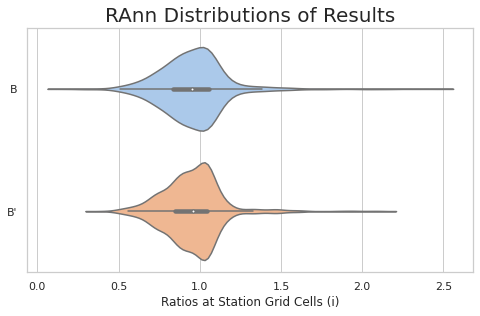

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 65.45255357058805 
UAA_station_mean 31.5 
Combined 48.476276785294026


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: mm


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)